# Idea
Do some training

In [2]:
SEED = 133

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import pickle

In [4]:
import sys
repo_base_path = Path("./../../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))

# from py_dataset import get_all_files_df
# from py_dataset import read_in_files
from py_dataset import feature_plotting
# from py_dataset import feature_selection
# from py_dataset import net_feature_engineering
# from py_dataset import entropy_feature_engineering
# from py_dataset.classes import DataSource
from py_dataset import sys_func



In [5]:
df = pd.read_csv('../data/all_df_top34.csv')
df.set_index("timestamp", inplace=True)

In [21]:
df["label"].unique()

array(['1_normal', nan, '2_ransomware', '3_thetick', '4_bashlite',
       '5_httpbackdoor', '6_beurk', '7_backdoor', '8_bdvl', '9_xmrig'],
      dtype=object)

### Preprocessings
- remove Null values
- drop timestamp
- labelEncode
- normalize

In [22]:
print(df.shape)
old_df = df.copy()
df.dropna(axis=0, how='any', inplace=True)

print(df.shape)

(29427, 34)
(20345, 34)


In [23]:
df.reset_index(inplace=True, drop=True)

In [24]:
label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.transform(df['label'])

In [25]:
df = feature_plotting.test_transform_all_to_numeric_columns(df)

In [26]:
cols_to_exclude_from_scaling = ["label"]
vectors = feature_plotting.minmax_scale_features(df,remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)
# print(vectors.shape)
# print(" with dropped null: ", vectors.dropna(axis=0, how='any', inplace=False).shape)

In [27]:
df["label"].unique(), vectors["label"].unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

### Setup

In [28]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomeDataset(Dataset):
    def __init__(self, some_df:pd.DataFrame):
        
        self.x = torch.tensor(some_df.drop(columns=["label"], inplace=False).values, dtype=torch.float32)
        self.labels = torch.tensor(some_df["label"].values, dtype=torch.uint8)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # print(self.x[idx], self.labels[idx])
        return self.x[idx], self.labels[idx]

In [29]:
from mlp_single_layer import MalwaresModelLinearLayer
from torch.utils.data import DataLoader
import lightning
from sklearn.model_selection import train_test_split
from lightning import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

# tensorboard = pl_loggers.TensorBoardLogger('./')

# split into train and val
train, val = train_test_split(vectors, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True) #logger=None, 


model = MalwaresModelLinearLayer(input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_))

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 306   
------------------------------------------------------------
306       Trainable params
0         Non-trainable params
306       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   0,   0,   0,   0, 108,   0,   0],
        [  0,   0,   0,   0,   0,   0, 116,   0,   0],
        [  0,   0,   0,   0,   0,   0, 144,   0,   0],
        [  0,   0,   0,   0,   0,   0,  94,   0,   0],
        [  0,   0,   0,   0,   0,   0,  93,   0,   0],
        [  0,   0,   0,   0,   0,   0, 120,   0,   0],
        [  0,   0,   0,   0,   0,   0, 106,   0,   0],
        [  0,   0,   0,   0,   0,   0, 100,   0,   0],
        [  0,   0,   0,   0,   0,   2, 117,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,    0, 1926,    0,    0,    0,  195,    3,    0],
        [   0, 1626,  355,    0,   77,    0,  233,    0,    0],
        [   0,    8, 3340,    0,    0,    0,  284,    6,    0],
        [   0,    0, 2003,    0,    0,    0,  183,    1,    0],
        [   0,    0, 2008,    0,    0,    0,  180,    5,    0],
        [   0,    1, 2008,    0,    0,    0,  194,   22,    0],
        [   0,    0, 1998,    0,    0,    0,  194,    2,    0],
        [   0,    0, 1999,    0,    0,    0,  161,   70,    0],
        [   0,    0,    1,    0,    0,    2,  247,    0, 2013]])


Metric Validation/Accuracy improved. New best score: 0.344


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,    0, 1926,    0,    0,    0,  195,    3,    0],
        [   0, 1626,  355,    0,   77,    0,  233,    0,    0],
        [   0,    8, 3340,    0,    0,    0,  284,    6,    0],
        [   0,    0, 2003,    0,    0,    0,  183,    1,    0],
        [   0,    0, 2008,    0,    0,    0,  180,    5,    0],
        [   0,    1, 2008,    0,    0,    0,  194,   22,    0],
        [   0,    0, 1998,    0,    0,    0,  194,    2,    0],
        [   0,    0, 1999,    0,    0,    0,  161,   70,    0],
        [   0,    0,    1,    0,    0,    2,  247,    0, 2013]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[   0,    0, 3872,    0,    0,    0,  195,   73,    0],
        [   0, 3801,  355,    0,   77,    0,  233,    0,    0],
        [   0,   22, 6724,    0,    0,    0,  284,  102,    0],
        [   0,    0, 4041,    0,    0,    0,  183,   56,    0],
        [   0,    0, 4014,    0,    4,    0,  180,   95,    0],
        [   0,    4, 3855,    0,    0,    6,  194,  271,    0],
        [   3,    0, 3999,    0,    0,    0,  194,   86,    0],
        [   0,    0, 3287,    0,    0,    0,  161,  912,    0],
        [   0,    0,    1,    0,    0,    2,  247,    0, 4157]])


Metric Validation/Accuracy improved by 0.052 >= min_delta = 0.0. New best score: 0.396


Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[   0,    0, 3872,    0,    0,    0,  195,   73,    0],
        [   0, 3801,  355,    0,   77,    0,  233,    0,    0],
        [   0,   22, 6724,    0,    0,    0,  284,  102,    0],
        [   0,    0, 4041,    0,    0,    0,  183,   56,    0],
        [   0,    0, 4014,    0,    4,    0,  180,   95,    0],
        [   0,    4, 3855,    0,    0,    6,  194,  271,    0],
        [   3,    0, 3999,    0,    0,    0,  194,   86,    0],
        [   0,    0, 3287,    0,    0,    0,  161,  912,    0],
        [   0,    0,    1,    0,    0,    2,  247,    0, 4157]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[   9,    0, 5702,    3,    0,    0,  195,  247,    0],
        [   0, 5976,  355,    0,   77,    0,  233,    0,    0],
        [   8,   38, 9991,    0,    0,    0,  284,  305,    0],
        [  14,    0, 5995,    2,    0,    1,  183,  178,    0],
        [  14,    0, 5837,    0,   76,    5,  180,  281,    0],
        [   2,    7, 5347,    1,    0,  120,  194,  764,    0],
        [  10,    0, 5906,    2,    0,    3,  194,  255,    0],
        [   2,    0, 3926,    1,    0,   13,  161, 2387,    0],
        [   0,    0,    1,    0,    0,    2,  247,    0, 6301]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[   9,    0, 5702,    3,    0,    0,  195,  247,    0],
        [   0, 5976,  355,    0,   77,    0,  233,    0,    0],
        [   8,   38, 9991,    0,    0,    0,  284,  305,    0],
        [  14,    0, 5995,    2,    0,    1,  183,  178,    0],
        [  14,    0, 5837,    0,   76,    5,  180,  281,   

Metric Validation/Accuracy improved by 0.033 >= min_delta = 0.0. New best score: 0.430


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[   63,     0,  7455,     3,     0,     0,   195,   456,     0],
        [    0,  8151,   355,     0,    77,     0,   233,     0,     0],
        [   41,    52, 13216,     0,     0,     0,   284,   527,     0],
        [   49,     0,  7919,     2,     0,     3,   183,   310,     0],
        [   41,     0,  7530,     0,   227,    11,   180,   504,     0],
        [   14,     9,  6673,     1,     2,   325,   194,  1322,     0],
        [   31,     0,  7761,     2,     0,     7,   194,   463,     0],
        [   14,     0,  4385,     1,     0,    29,   161,  4030,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0,  8445]])
Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[   63,     0,  7455,     3,     0,     0,   195,   456,     0],
        [    0,  8151,   355,     0,    77,     0,   233,     0,     0],
        [   41,    52, 13216,     0,     0,     0,   284,   527,     0],
        [   49,

Metric Validation/Accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.442


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[  160,     0,  9127,     6,     3,     0,   195,   697,     0],
        [    0, 10326,   355,     0,    77,     0,   233,     0,     0],
        [   97,    61, 16363,     0,    11,     0,   284,   798,     0],
        [  122,     0,  9749,    19,    10,     6,   183,   470,     0],
        [   80,     0,  9000,     3,   550,    31,   180,   749,     0],
        [   38,     9,  7738,     4,    30,   727,   194,  1905,     0],
        [   68,     0,  9544,     8,     7,    18,   194,   707,     0],
        [   26,     0,  4702,     2,     5,    52,   161,  5802,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 10589]])


Metric Validation/Accuracy improved by 0.028 >= min_delta = 0.0. New best score: 0.470


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[  160,     0,  9127,     6,     3,     0,   195,   697,     0],
        [    0, 10326,   355,     0,    77,     0,   233,     0,     0],
        [   97,    61, 16363,     0,    11,     0,   284,   798,     0],
        [  122,     0,  9749,    19,    10,     6,   183,   470,     0],
        [   80,     0,  9000,     3,   550,    31,   180,   749,     0],
        [   38,     9,  7738,     4,    30,   727,   194,  1905,     0],
        [   68,     0,  9544,     8,     7,    18,   194,   707,     0],
        [   26,     0,  4702,     2,     5,    52,   161,  5802,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 10589]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[  311,     0, 10761,    12,     9,     1,   195,   915,     0],
        [    0, 12501,   355,     0,    77,     0,   233,     0,     0],
        [  195,    69, 19518,     1,    14,     2,   284,  1025,     0],
        [  227,     0, 11544,    48,    20,    11,   183,   619,     0],
        [  144,     0, 10395,     4,   934,    68,   180,   968,     0],
        [   70,     9,  8679,     8,    64,  1284,   194,  2442,     0],
        [  123,     0, 11308,    11,    11,    48,   194,   939,     0],
        [   43,     0,  4960,     2,    10,    76,   161,  7628,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 12733]])
Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[  311,     0, 10761,    12,     9,     1,   195,   915,     0],
        [    0, 12501,   355,     0,    77,     0,   233,     0,     0],
        [  195,    69, 19518,     1,    14,     2,   284,  1025,     0],
        [  227,

Metric Validation/Accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.482


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[  496,     0, 12332,    46,    19,     6,   195,  1126,     0],
        [    0, 14674,   355,     0,    77,     2,   233,     0,     0],
        [  298,    77, 22627,    27,    29,     7,   284,  1253,     0],
        [  344,     0, 13237,   174,    34,    19,   183,   754,     0],
        [  205,     0, 11665,    17,  1428,   121,   180,  1177,     0],
        [   97,     9,  9485,    25,   112,  1982,   194,  2951,     0],
        [  183,     0, 13049,    29,    27,    91,   194,  1149,     0],
        [   61,     0,  5169,     3,    18,   114,   161,  9484,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 14877]])


Metric Validation/Accuracy improved by 0.026 >= min_delta = 0.0. New best score: 0.507


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[  496,     0, 12332,    46,    19,     6,   195,  1126,     0],
        [    0, 14674,   355,     0,    77,     2,   233,     0,     0],
        [  298,    77, 22627,    27,    29,     7,   284,  1253,     0],
        [  344,     0, 13237,   174,    34,    19,   183,   754,     0],
        [  205,     0, 11665,    17,  1428,   121,   180,  1177,     0],
        [   97,     9,  9485,    25,   112,  1982,   194,  2951,     0],
        [  183,     0, 13049,    29,    27,    91,   194,  1149,     0],
        [   61,     0,  5169,     3,    18,   114,   161,  9484,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 14877]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[  752,     0, 13826,    74,    34,    16,   195,  1339,     0],
        [    0, 16848,   355,     0,    77,     3,   233,     0,     0],
        [  446,    85, 25712,    42,    43,    20,   284,  1464,     0],
        [  498,     0, 14878,   313,    50,    32,   183,   884,     0],
        [  289,     0, 12814,    30,  2018,   185,   180,  1377,     0],
        [  132,     9, 10133,    43,   179,  2824,   194,  3446,     0],
        [  281,     0, 14733,    39,    46,   153,   194,  1364,     0],
        [   81,     0,  5314,     6,    25,   157,   161, 11396,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 17021]])


Metric Validation/Accuracy improved by 0.019 >= min_delta = 0.0. New best score: 0.527


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[  752,     0, 13826,    74,    34,    16,   195,  1339,     0],
        [    0, 16848,   355,     0,    77,     3,   233,     0,     0],
        [  446,    85, 25712,    42,    43,    20,   284,  1464,     0],
        [  498,     0, 14878,   313,    50,    32,   183,   884,     0],
        [  289,     0, 12814,    30,  2018,   185,   180,  1377,     0],
        [  132,     9, 10133,    43,   179,  2824,   194,  3446,     0],
        [  281,     0, 14733,    39,    46,   153,   194,  1364,     0],
        [   81,     0,  5314,     6,    25,   157,   161, 11396,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 17021]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 1071,     0, 15259,   121,    44,    32,   195,  1530,     0],
        [    0, 19020,   355,     0,    77,     6,   233,     0,     0],
        [  609,    93, 28794,    68,    60,    34,   284,  1648,     0],
        [  674,     0, 16458,   504,    63,    52,   183,   997,     0],
        [  384,     0, 13920,    56,  2635,   263,   180,  1555,     0],
        [  174,     9, 10699,    61,   254,  3795,   194,  3879,     0],
        [  392,     0, 16411,    55,    67,   228,   194,  1551,     0],
        [  105,     0,  5443,    10,    36,   202,   161, 13313,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 19165]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.530


Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[ 1071,     0, 15259,   121,    44,    32,   195,  1530,     0],
        [    0, 19020,   355,     0,    77,     6,   233,     0,     0],
        [  609,    93, 28794,    68,    60,    34,   284,  1648,     0],
        [  674,     0, 16458,   504,    63,    52,   183,   997,     0],
        [  384,     0, 13920,    56,  2635,   263,   180,  1555,     0],
        [  174,     9, 10699,    61,   254,  3795,   194,  3879,     0],
        [  392,     0, 16411,    55,    67,   228,   194,  1551,     0],
        [  105,     0,  5443,    10,    36,   202,   161, 13313,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 19165]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[ 1433,     0, 16628,   177,    69,    53,   195,  1713,     0],
        [    0, 21192,   355,     0,    77,     9,   233,     0,     0],
        [  778,   101, 31837,    92,    94,    64,   284,  1834,     0],
        [  847,     0, 18000,   726,    94,    76,   183,  1098,     0],
        [  480,     0, 14917,    89,  3352,   363,   180,  1712,     0],
        [  211,     9, 11127,    90,   338,  4947,   194,  4254,     0],
        [  509,     0, 18049,    79,    95,   330,   194,  1730,     0],
        [  124,     0,  5550,    13,    57,   249,   161, 15246,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 21309]])


Metric Validation/Accuracy improved by 0.030 >= min_delta = 0.0. New best score: 0.559


Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[ 1433,     0, 16628,   177,    69,    53,   195,  1713,     0],
        [    0, 21192,   355,     0,    77,     9,   233,     0,     0],
        [  778,   101, 31837,    92,    94,    64,   284,  1834,     0],
        [  847,     0, 18000,   726,    94,    76,   183,  1098,     0],
        [  480,     0, 14917,    89,  3352,   363,   180,  1712,     0],
        [  211,     9, 11127,    90,   338,  4947,   194,  4254,     0],
        [  509,     0, 18049,    79,    95,   330,   194,  1730,     0],
        [  124,     0,  5550,    13,    57,   249,   161, 15246,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 21309]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[ 1837,     0, 17937,   250,    96,    71,   195,  1898,     0],
        [    0, 23364,   355,     0,    77,    12,   233,     0,     0],
        [  957,   109, 34876,   129,   123,    89,   284,  2011,     0],
        [ 1011,     0, 19502,  1008,   122,   100,   183,  1191,     0],
        [  569,     0, 15861,   141,  4114,   460,   180,  1868,     0],
        [  253,     9, 11533,   126,   435,  6077,   194,  4648,     0],
        [  636,     0, 19682,   109,   120,   431,   194,  1902,     0],
        [  146,     0,  5633,    16,    78,   282,   161, 17214,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 23453]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.561


Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[ 1837,     0, 17937,   250,    96,    71,   195,  1898,     0],
        [    0, 23364,   355,     0,    77,    12,   233,     0,     0],
        [  957,   109, 34876,   129,   123,    89,   284,  2011,     0],
        [ 1011,     0, 19502,  1008,   122,   100,   183,  1191,     0],
        [  569,     0, 15861,   141,  4114,   460,   180,  1868,     0],
        [  253,     9, 11533,   126,   435,  6077,   194,  4648,     0],
        [  636,     0, 19682,   109,   120,   431,   194,  1902,     0],
        [  146,     0,  5633,    16,    78,   282,   161, 17214,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 23453]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[ 2229,     0, 19226,   370,   118,    98,   195,  2064,     0],
        [    0, 25536,   355,     0,    77,    15,   233,     0,     0],
        [ 1114,   117, 37931,   195,   153,   134,   284,  2144,     0],
        [ 1175,     0, 20923,  1376,   151,   125,   184,  1276,     0],
        [  652,     0, 16777,   213,  4873,   575,   180,  2023,     0],
        [  286,     9, 11881,   169,   523,  7332,   194,  4986,     0],
        [  747,     0, 21283,   172,   147,   550,   196,  2067,     0],
        [  166,     0,  5700,    23,    93,   322,   161, 19195,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 25597]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[ 2229,     0, 19226,   370,   118,    98,   195,  2064,     0],
        [    0, 25536,   355,     0,    77,    15,   233,     0,     0],
        [ 1114,   117, 37931,   195,   153,   134,   284,  2144,     0],
        [ 117

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[ 2669,     0, 20472,   476,   148,   123,   195,  2233,     0],
        [    0, 27708,   355,     0,    77,    18,   233,     0,     0],
        [ 1290,   125, 40993,   247,   184,   175,   284,  2268,     0],
        [ 1334,     0, 22345,  1744,   183,   159,   184,  1354,     0],
        [  744,     0, 17636,   271,  5710,   687,   180,  2165,     0],
        [  318,     9, 12205,   218,   628,  8585,   194,  5328,     0],
        [  863,     0, 22881,   239,   178,   664,   199,  2226,     0],
        [  188,     0,  5756,    27,   114,   341,   161, 21203,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 27741]])


Metric Validation/Accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.576


Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[ 2669,     0, 20472,   476,   148,   123,   195,  2233,     0],
        [    0, 27708,   355,     0,    77,    18,   233,     0,     0],
        [ 1290,   125, 40993,   247,   184,   175,   284,  2268,     0],
        [ 1334,     0, 22345,  1744,   183,   159,   184,  1354,     0],
        [  744,     0, 17636,   271,  5710,   687,   180,  2165,     0],
        [  318,     9, 12205,   218,   628,  8585,   194,  5328,     0],
        [  863,     0, 22881,   239,   178,   664,   199,  2226,     0],
        [  188,     0,  5756,    27,   114,   341,   161, 21203,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 27741]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[ 3171,     0, 21669,   594,   175,   150,   197,  2376,     0],
        [    0, 29880,   355,     0,    77,    21,   233,     0,     0],
        [ 1478,   133, 44029,   300,   214,   232,   288,  2386,     0],
        [ 1498,     0, 23691,  2186,   222,   196,   184,  1419,     0],
        [  840,     0, 18471,   352,  6532,   819,   182,  2297,     0],
        [  353,     9, 12469,   273,   727,  9957,   194,  5608,     0],
        [ 1002,     0, 24445,   314,   213,   803,   202,  2359,     0],
        [  211,     0,  5799,    33,   133,   382,   161, 23201,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 29885]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[ 3171,     0, 21669,   594,   175,   150,   197,  2376,     0],
        [    0, 29880,   355,     0,    77,    21,   233,     0,     0],
        [ 1478,   133, 44029,   300,   214,   232,   288,  2386,     0],
        [ 149

Metric Validation/Accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.588


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[ 3672,     0, 22816,   764,   209,   175,   198,  2514,     0],
        [    0, 32052,   355,     0,    77,    24,   233,     0,     0],
        [ 1648,   141, 47035,   405,   252,   289,   291,  2493,     0],
        [ 1658,     0, 24988,  2680,   267,   240,   184,  1472,     0],
        [  923,     0, 19271,   444,  7404,   946,   183,  2422,     0],
        [  385,     9, 12723,   346,   827, 11350,   194,  5861,     0],
        [ 1126,     0, 25995,   420,   257,   940,   208,  2480,     0],
        [  232,     0,  5841,    41,   153,   408,   161, 25214,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 32029]])


Metric Validation/Accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.602


Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[ 3672,     0, 22816,   764,   209,   175,   198,  2514,     0],
        [    0, 32052,   355,     0,    77,    24,   233,     0,     0],
        [ 1648,   141, 47035,   405,   252,   289,   291,  2493,     0],
        [ 1658,     0, 24988,  2680,   267,   240,   184,  1472,     0],
        [  923,     0, 19271,   444,  7404,   946,   183,  2422,     0],
        [  385,     9, 12723,   346,   827, 11350,   194,  5861,     0],
        [ 1126,     0, 25995,   420,   257,   940,   208,  2480,     0],
        [  232,     0,  5841,    41,   153,   408,   161, 25214,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 32029]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[ 4338,     0, 23877,   852,   251,   201,   201,  2644,     0],
        [    0, 34224,   355,     0,    77,    27,   233,     0,     0],
        [ 1899,   149, 50030,   440,   289,   354,   296,  2591,     0],
        [ 1891,     0, 26299,  3095,   314,   281,   185,  1517,     0],
        [ 1032,     0, 20055,   510,  8306,  1071,   185,  2534,     0],
        [  428,     9, 12952,   389,   947, 12781,   194,  6100,     0],
        [ 1297,     0, 27531,   473,   321,  1084,   218,  2590,     0],
        [  254,     0,  5868,    46,   176,   424,   161, 27251,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 34173]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[ 4338,     0, 23877,   852,   251,   201,   201,  2644,     0],
        [    0, 34224,   355,     0,    77,    27,   233,     0,     0],
        [ 1899,   149, 50030,   440,   289,   354,   296,  2591,     0],
        [ 189

Metric Validation/Accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.614


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[ 5011,     0, 24888,   977,   294,   234,   204,  2772,     0],
        [    0, 36396,   355,     0,    77,    30,   233,     0,     0],
        [ 2126,   157, 52999,   497,   332,   433,   307,  2691,     0],
        [ 2095,     0, 27509,  3621,   376,   325,   185,  1564,     0],
        [ 1136,     0, 20779,   593,  9258,  1197,   188,  2642,     0],
        [  462,     9, 13126,   449,  1074, 14260,   194,  6331,     0],
        [ 1464,     0, 29023,   554,   387,  1243,   225,  2706,     0],
        [  272,     0,  5894,    53,   198,   436,   161, 29296,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 36317]])


Metric Validation/Accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.629


Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[ 5011,     0, 24888,   977,   294,   234,   204,  2772,     0],
        [    0, 36396,   355,     0,    77,    30,   233,     0,     0],
        [ 2126,   157, 52999,   497,   332,   433,   307,  2691,     0],
        [ 2095,     0, 27509,  3621,   376,   325,   185,  1564,     0],
        [ 1136,     0, 20779,   593,  9258,  1197,   188,  2642,     0],
        [  462,     9, 13126,   449,  1074, 14260,   194,  6331,     0],
        [ 1464,     0, 29023,   554,   387,  1243,   225,  2706,     0],
        [  272,     0,  5894,    53,   198,   436,   161, 29296,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 36317]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[ 5681,     0, 25940,  1082,   334,   265,   204,  2890,     0],
        [    0, 38568,   355,     0,    77,    33,   233,     0,     0],
        [ 2339,   165, 56002,   562,   371,   508,   313,  2776,     0],
        [ 2290,     0, 28755,  4129,   424,   372,   189,  1609,     0],
        [ 1234,     0, 21494,   677, 10217,  1330,   192,  2749,     0],
        [  496,     9, 13316,   508,  1199, 15747,   194,  6541,     0],
        [ 1625,     0, 30553,   629,   440,  1405,   235,  2803,     0],
        [  293,     0,  5913,    60,   217,   447,   161, 31349,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 38461]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[ 5681,     0, 25940,  1082,   334,   265,   204,  2890,     0],
        [    0, 38568,   355,     0,    77,    33,   233,     0,     0],
        [ 2339,   165, 56002,   562,   371,   508,   313,  2776,     0],
        [ 229

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[ 6288,     0, 26996,  1246,   377,   295,   210,  3000,     0],
        [    0, 40740,   355,     0,    77,    36,   233,     0,     0],
        [ 2517,   173, 59001,   648,   417,   588,   329,  2857,     0],
        [ 2436,     0, 29963,  4724,   473,   421,   192,  1652,     0],
        [ 1321,     0, 22188,   785, 11185,  1469,   201,  2844,     0],
        [  520,     9, 13464,   579,  1322, 17304,   194,  6723,     0],
        [ 1765,     0, 32051,   734,   505,  1582,   252,  2889,     0],
        [  312,     0,  5934,    67,   237,   458,   161, 33401,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 40605]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[ 6288,     0, 26996,  1246,   377,   295,   210,  3000,     0],
        [    0, 40740,   355,     0,    77,    36,   233,     0,     0],
        [ 2517,   173, 59001,   648,   417,   588,   329,  2857,     0],
        [ 243

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[ 7007,     0, 27962,  1382,   422,   333,   215,  3107,     0],
        [    0, 42912,   355,     0,    77,    39,   233,     0,     0],
        [ 2735,   181, 61969,   722,   460,   668,   351,  2938,     0],
        [ 2620,     0, 31142,  5304,   526,   468,   200,  1694,     0],
        [ 1419,     0, 22857,   882, 12185,  1601,   213,  2936,     0],
        [  551,     9, 13599,   650,  1450, 18852,   194,  6915,     0],
        [ 1913,     0, 33540,   838,   569,  1755,   275,  2976,     0],
        [  331,     0,  5946,    73,   258,   468,   161, 35463,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 42749]])


Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.634


Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[ 7007,     0, 27962,  1382,   422,   333,   215,  3107,     0],
        [    0, 42912,   355,     0,    77,    39,   233,     0,     0],
        [ 2735,   181, 61969,   722,   460,   668,   351,  2938,     0],
        [ 2620,     0, 31142,  5304,   526,   468,   200,  1694,     0],
        [ 1419,     0, 22857,   882, 12185,  1601,   213,  2936,     0],
        [  551,     9, 13599,   650,  1450, 18852,   194,  6915,     0],
        [ 1913,     0, 33540,   838,   569,  1755,   275,  2976,     0],
        [  331,     0,  5946,    73,   258,   468,   161, 35463,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 42749]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[ 7700,     0, 28943,  1532,   471,   382,   217,  3199,     0],
        [    0, 45084,   355,     0,    77,    42,   233,     0,     0],
        [ 2933,   189, 64933,   830,   505,   756,   367,  3005,     0],
        [ 2770,     0, 32309,  5929,   574,   529,   202,  1734,     0],
        [ 1509,     0, 23521,   993, 13190,  1757,   215,  3008,     0],
        [  575,     9, 13720,   724,  1574, 20458,   194,  7071,     0],
        [ 2057,     0, 35012,   953,   638,  1949,   288,  3057,     0],
        [  350,     0,  5963,    79,   277,   484,   161, 37516,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 44893]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[ 7700,     0, 28943,  1532,   471,   382,   217,  3199,     0],
        [    0, 45084,   355,     0,    77,    42,   233,     0,     0],
        [ 2933,   189, 64933,   830,   505,   756,   367,  3005,     0],
        [ 277

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[ 8368,     0, 29953,  1694,   517,   417,   220,  3291,     0],
        [    0, 47256,   355,     0,    77,    45,   233,     0,     0],
        [ 3111,   197, 67952,   933,   551,   825,   383,  3060,     0],
        [ 2922,     0, 33488,  6555,   624,   579,   206,  1766,     0],
        [ 1588,     0, 24199,  1097, 14213,  1898,   221,  3077,     0],
        [  600,     9, 13857,   786,  1700, 22059,   194,  7225,     0],
        [ 2205,     0, 36507,  1068,   704,  2130,   299,  3129,     0],
        [  368,     0,  5979,    86,   296,   490,   161, 39580,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 47037]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[ 8368,     0, 29953,  1694,   517,   417,   220,  3291,     0],
        [    0, 47256,   355,     0,    77,    45,   233,     0,     0],
        [ 3111,   197, 67952,   933,   551,   825,   383,  3060,     0],
        [ 292

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[ 9082,     0, 30889,  1870,   567,   463,   226,  3379,     0],
        [    0, 49428,   355,     0,    77,    48,   233,     0,     0],
        [ 3303,   205, 70915,  1051,   611,   906,   401,  3114,     0],
        [ 3089,     0, 34596,  7214,   689,   629,   218,  1798,     0],
        [ 1671,     0, 24811,  1225, 15280,  2039,   235,  3132,     0],
        [  623,     9, 13967,   869,  1829, 23672,   194,  7372,     0],
        [ 2336,     0, 37942,  1212,   788,  2324,   328,  3200,     0],
        [  382,     0,  5993,    95,   314,   499,   161, 41646,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 49181]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.638


Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[ 9082,     0, 30889,  1870,   567,   463,   226,  3379,     0],
        [    0, 49428,   355,     0,    77,    48,   233,     0,     0],
        [ 3303,   205, 70915,  1051,   611,   906,   401,  3114,     0],
        [ 3089,     0, 34596,  7214,   689,   629,   218,  1798,     0],
        [ 1671,     0, 24811,  1225, 15280,  2039,   235,  3132,     0],
        [  623,     9, 13967,   869,  1829, 23672,   194,  7372,     0],
        [ 2336,     0, 37942,  1212,   788,  2324,   328,  3200,     0],
        [  382,     0,  5993,    95,   314,   499,   161, 41646,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 49181]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[ 9888,     0, 31735,  2053,   621,   510,   233,  3452,     0],
        [    0, 51600,   355,     0,    77,    51,   233,     0,     0],
        [ 3512,   213, 73845,  1165,   670,   997,   428,  3170,     0],
        [ 3274,     0, 35667,  7901,   746,   686,   220,  1832,     0],
        [ 1762,     0, 25405,  1355, 16348,  2190,   248,  3185,     0],
        [  651,     9, 14060,   947,  1960, 25313,   194,  7506,     0],
        [ 2478,     0, 39349,  1375,   864,  2526,   356,  3270,     0],
        [  400,     0,  6003,   101,   330,   506,   161, 43719,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 51325]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[ 9888,     0, 31735,  2053,   621,   510,   233,  3452,     0],
        [    0, 51600,   355,     0,    77,    51,   233,     0,     0],
        [ 3512,   213, 73845,  1165,   670,   997,   428,  3170,     0],
        [ 327

Metric Validation/Accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.656


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[10679,     0, 32597,  2249,   667,   555,   241,  3520,     0],
        [    0, 53772,   355,     0,    77,    54,   233,     0,     0],
        [ 3719,   221, 76788,  1290,   722,  1082,   450,  3222,     0],
        [ 3419,     0, 36761,  8610,   799,   743,   228,  1859,     0],
        [ 1849,     0, 26018,  1484, 17414,  2336,   258,  3234,     0],
        [  674,     9, 14152,  1036,  2091, 26958,   194,  7631,     0],
        [ 2617,     0, 40797,  1524,   937,  2720,   378,  3333,     0],
        [  420,     0,  6013,   107,   347,   514,   161, 45788,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 53469]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[10679,     0, 32597,  2249,   667,   555,   241,  3520,     0],
        [    0, 53772,   355,     0,    77,    54,   233,     0,     0],
        [ 3719,   221, 76788,  1290,   722,  1082,   450,  3222,     0],
        [ 341

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[11464,     0, 33471,  2440,   719,   601,   250,  3579,     0],
        [    0, 55944,   355,     0,    77,    57,   233,     0,     0],
        [ 3923,   228, 79740,  1409,   775,  1166,   473,  3274,     0],
        [ 3553,     0, 37847,  9336,   860,   800,   231,  1885,     0],
        [ 1935,     0, 26605,  1623, 18504,  2479,   269,  3278,     0],
        [  695,     9, 14244,  1117,  2226, 28614,   194,  7751,     0],
        [ 2744,     0, 42242,  1687,  1012,  2915,   401,  3393,     0],
        [  437,     0,  6023,   112,   366,   522,   161, 47859,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 55613]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[11464,     0, 33471,  2440,   719,   601,   250,  3579,     0],
        [    0, 55944,   355,     0,    77,    57,   233,     0,     0],
        [ 3923,   228, 79740,  1409,   775,  1166,   473,  3274,     0],
        [ 355

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[12278,     0, 34288,  2629,   789,   650,   270,  3636,     0],
        [    0, 58116,   355,     0,    77,    60,   233,     0,     0],
        [ 4123,   228, 82670,  1538,   849,  1247,   504,  3323,     0],
        [ 3685,     0, 38912, 10066,   933,   866,   237,  1906,     0],
        [ 2028,     0, 27158,  1753, 19627,  2628,   289,  3310,     0],
        [  716,     9, 14326,  1200,  2371, 30278,   194,  7861,     0],
        [ 2879,     0, 43637,  1863,  1106,  3111,   439,  3447,     0],
        [  449,     0,  6032,   122,   387,   529,   161, 49930,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 57757]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[12278,     0, 34288,  2629,   789,   650,   270,  3636,     0],
        [    0, 58116,   355,     0,    77,    60,   233,     0,     0],
        [ 4123,   228, 82670,  1538,   849,  1247,   504,  3323,     0],
        [ 368

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[13112,     0, 35099,  2828,   852,   694,   282,  3689,     0],
        [    0, 60288,   355,     0,    77,    63,   233,     0,     0],
        [ 4319,   228, 85613,  1694,   913,  1310,   536,  3363,     0],
        [ 3803,     0, 39948, 10849,   999,   929,   242,  1928,     0],
        [ 2110,     0, 27705,  1898, 20752,  2778,   310,  3340,     0],
        [  738,     9, 14413,  1289,  2525, 31923,   195,  7968,     0],
        [ 3019,     0, 45038,  2040,  1190,  3299,   480,  3504,     0],
        [  465,     0,  6042,   126,   406,   535,   161, 52005,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 59901]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[13112,     0, 35099,  2828,   852,   694,   282,  3689,     0],
        [    0, 60288,   355,     0,    77,    63,   233,     0,     0],
        [ 4319,   228, 85613,  1694,   913,  1310,   536,  3363,     0],
        [ 380

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[13969,     0, 35894,  3027,   905,   737,   294,  3746,     0],
        [    0, 62460,   355,     0,    77,    66,   233,     0,     0],
        [ 4508,   228, 88565,  1849,   963,  1394,   565,  3398,     0],
        [ 3926,     0, 40983, 11642,  1055,   985,   250,  1950,     0],
        [ 2188,     0, 28275,  2045, 21859,  2930,   324,  3372,     0],
        [  759,     9, 14499,  1375,  2660, 33604,   195,  8064,     0],
        [ 3155,     0, 46453,  2211,  1266,  3504,   510,  3559,     0],
        [  480,     0,  6051,   130,   423,   545,   161, 54080,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 62045]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.664


Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[13969,     0, 35894,  3027,   905,   737,   294,  3746,     0],
        [    0, 62460,   355,     0,    77,    66,   233,     0,     0],
        [ 4508,   228, 88565,  1849,   963,  1394,   565,  3398,     0],
        [ 3926,     0, 40983, 11642,  1055,   985,   250,  1950,     0],
        [ 2188,     0, 28275,  2045, 21859,  2930,   324,  3372,     0],
        [  759,     9, 14499,  1375,  2660, 33604,   195,  8064,     0],
        [ 3155,     0, 46453,  2211,  1266,  3504,   510,  3559,     0],
        [  480,     0,  6051,   130,   423,   545,   161, 54080,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 62045]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[14885,     0, 36671,  3193,   958,   782,   304,  3795,     0],
        [    0, 64632,   355,     0,    77,    69,   233,     0,     0],
        [ 4718,   228, 91511,  1981,  1030,  1475,   593,  3428,     0],
        [ 4093,     0, 42012, 12377,  1123,  1049,   262,  1968,     0],
        [ 2282,     0, 28824,  2183, 22975,  3085,   342,  3402,     0],
        [  782,     9, 14584,  1451,  2789, 35305,   195,  8155,     0],
        [ 3308,     0, 47843,  2374,  1356,  3708,   548,  3609,     0],
        [  493,     0,  6060,   135,   439,   553,   161, 56159,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 64189]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[14885,     0, 36671,  3193,   958,   782,   304,  3795,     0],
        [    0, 64632,   355,     0,    77,    69,   233,     0,     0],
        [ 4718,   228, 91511,  1981,  1030,  1475,   593,  3428,     0],
        [ 409

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[15804,     0, 37460,  3345,  1011,   832,   315,  3837,     0],
        [    0, 66804,   355,     0,    77,    72,   233,     0,     0],
        [ 4917,   228, 94470,  2116,  1099,  1556,   616,  3456,     0],
        [ 4279,     0, 43059, 13079,  1189,  1116,   269,  1986,     0],
        [ 2380,     0, 29390,  2311, 24088,  3242,   358,  3424,     0],
        [  805,     9, 14655,  1532,  2925, 37016,   195,  8238,     0],
        [ 3456,     0, 49251,  2533,  1435,  3919,   587,  3653,     0],
        [  506,     0,  6067,   141,   457,   562,   161, 58236,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 66333]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.667


Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[15804,     0, 37460,  3345,  1011,   832,   315,  3837,     0],
        [    0, 66804,   355,     0,    77,    72,   233,     0,     0],
        [ 4917,   228, 94470,  2116,  1099,  1556,   616,  3456,     0],
        [ 4279,     0, 43059, 13079,  1189,  1116,   269,  1986,     0],
        [ 2380,     0, 29390,  2311, 24088,  3242,   358,  3424,     0],
        [  805,     9, 14655,  1532,  2925, 37016,   195,  8238,     0],
        [ 3456,     0, 49251,  2533,  1435,  3919,   587,  3653,     0],
        [  506,     0,  6067,   141,   457,   562,   161, 58236,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 66333]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[16748,     0, 38171,  3545,  1068,   877,   336,  3875,     0],
        [    0, 68976,   355,     0,    77,    75,   233,     0,     0],
        [ 5114,   228, 97383,  2275,  1172,  1642,   655,  3483,     0],
        [ 4407,     0, 44033, 13909,  1253,  1179,   285,  2004,     0],
        [ 2464,     0, 29895,  2455, 25257,  3395,   376,  3451,     0],
        [  826,     9, 14722,  1618,  3067, 38723,   200,  8315,     0],
        [ 3589,     0, 50611,  2725,  1526,  4135,   638,  3698,     0],
        [  519,     0,  6074,   146,   473,   569,   162, 60317,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 68477]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.672


Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[16748,     0, 38171,  3545,  1068,   877,   336,  3875,     0],
        [    0, 68976,   355,     0,    77,    75,   233,     0,     0],
        [ 5114,   228, 97383,  2275,  1172,  1642,   655,  3483,     0],
        [ 4407,     0, 44033, 13909,  1253,  1179,   285,  2004,     0],
        [ 2464,     0, 29895,  2455, 25257,  3395,   376,  3451,     0],
        [  826,     9, 14722,  1618,  3067, 38723,   200,  8315,     0],
        [ 3589,     0, 50611,  2725,  1526,  4135,   638,  3698,     0],
        [  519,     0,  6074,   146,   473,   569,   162, 60317,     0],
        [    0,     0,     1,     0,     0,     2,   247,     0, 68477]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[ 17655,      0,  38919,   3740,   1133,    923,    349,   3917,      0],
        [     0,  71148,    355,      0,     77,     78,    233,      0,      0],
        [  5302,    228, 100315,   2435,   1247,   1721,    691,   3507,      0],
        [  4533,      0,  45029,  14716,   1328,   1238,    297,   2022,      0],
        [  2543,      0,  30422,   2597,  26429,   3530,    398,   3474,      0],
        [   847,      9,  14791,   1702,   3212,  40428,    204,   8392,      0],
        [  3708,      0,  52004,   2915,   1619,   4343,    682,   3739,      0],
        [   533,      0,   6082,    149,    489,    575,    162,  62400,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  70621]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[ 17655,      0,  38919,   3740,   1133,    923,    349,   3917,      0],
        [     0,  71148,    355,      0,     77,     78,    233,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[ 18523,      0,  39685,   3966,   1187,    970,    365,   3956,      0],
        [     0,  73320,    355,      0,     77,     81,    233,      0,      0],
        [  5480,    228, 103248,   2607,   1320,   1797,    729,   3531,      0],
        [  4646,      0,  45999,  15567,   1390,   1296,    318,   2040,      0],
        [  2616,      0,  30926,   2743,  27604,   3681,    427,   3496,      0],
        [   866,      9,  14859,   1796,   3350,  42142,    205,   8463,      0],
        [  3816,      0,  53387,   3128,   1712,   4543,    737,   3775,      0],
        [   545,      0,   6090,    154,    502,    582,    163,  64484,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  72765]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[ 18523,      0,  39685,   3966,   1187,    970,    365,   3956,      0],
        [     0,  73320,    355,      0,     77,     81,    233,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[ 19441,      0,  40448,   4152,   1236,   1020,    381,   3990,      0],
        [     0,  75492,    355,      0,     77,     84,    233,      0,      0],
        [  5669,    228, 106203,   2765,   1377,   1872,    768,   3552,      0],
        [  4768,      0,  47015,  16373,   1451,   1353,    333,   2056,      0],
        [  2694,      0,  31462,   2884,  28756,   3824,    458,   3515,      0],
        [   887,      9,  14929,   1880,   3483,  43870,    207,   8530,      0],
        [  3939,      0,  54791,   3311,   1793,   4745,    799,   3808,      0],
        [   556,      0,   6098,    159,    515,    589,    163,  66570,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  74909]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[ 19441,      0,  40448,   4152,   1236,   1020,    381,   3990,      0],
        [     0,  75492,    355,      0,     77,     84,    233,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[ 20391,      0,  41151,   4355,   1300,   1063,    399,   4025,      0],
        [     0,  77664,    355,      0,     77,     87,    233,      0,      0],
        [  5853,    228, 109129,   2929,   1460,   1952,    802,   3575,      0],
        [  4889,      0,  47980,  17219,   1522,   1413,    345,   2074,      0],
        [  2774,      0,  31950,   3032,  29947,   3969,    485,   3536,      0],
        [   906,      9,  14985,   1964,   3631,  45601,    209,   8595,      0],
        [  4056,      0,  56158,   3518,   1893,   4946,    858,   3845,      0],
        [   570,      0,   6105,    162,    531,    598,    163,  68651,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  77053]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.674


Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[ 20391,      0,  41151,   4355,   1300,   1063,    399,   4025,      0],
        [     0,  77664,    355,      0,     77,     87,    233,      0,      0],
        [  5853,    228, 109129,   2929,   1460,   1952,    802,   3575,      0],
        [  4889,      0,  47980,  17219,   1522,   1413,    345,   2074,      0],
        [  2774,      0,  31950,   3032,  29947,   3969,    485,   3536,      0],
        [   906,      9,  14985,   1964,   3631,  45601,    209,   8595,      0],
        [  4056,      0,  56158,   3518,   1893,   4946,    858,   3845,      0],
        [   570,      0,   6105,    162,    531,    598,    163,  68651,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  77053]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[ 21350,      0,  41847,   4560,   1362,   1110,    415,   4056,      0],
        [     0,  79836,    355,      0,     77,     90,    233,      0,      0],
        [  6042,    228, 112066,   3093,   1527,   2029,    845,   3592,      0],
        [  5002,      0,  48926,  18089,   1594,   1473,    359,   2092,      0],
        [  2851,      0,  32425,   3182,  31153,   4117,    512,   3553,      0],
        [   926,      9,  15047,   2046,   3763,  47351,    211,   8652,      0],
        [  4179,      0,  57514,   3733,   1986,   5152,    922,   3876,      0],
        [   584,      0,   6114,    166,    544,    605,    163,  70734,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  79197]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[ 21350,      0,  41847,   4560,   1362,   1110,    415,   4056,      0],
        [     0,  79836,    355,      0,     77,     90,    233,     

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.678


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[ 22361,      0,  42529,   4740,   1422,   1152,    426,   4086,      0],
        [     0,  82008,    355,      0,     77,     93,    233,      0,      0],
        [  6232,    228, 115005,   3258,   1598,   2101,    881,   3613,      0],
        [  5126,      0,  49878,  18947,   1662,   1532,    373,   2110,      0],
        [  2929,      0,  32905,   3326,  32369,   4261,    531,   3572,      0],
        [   944,      9,  15102,   2139,   3901,  49092,    213,   8710,      0],
        [  4311,      0,  58882,   3941,   2082,   5352,    976,   3906,      0],
        [   597,      0,   6121,    170,    558,    613,    163,  72818,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  81341]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.680


Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[ 22361,      0,  42529,   4740,   1422,   1152,    426,   4086,      0],
        [     0,  82008,    355,      0,     77,     93,    233,      0,      0],
        [  6232,    228, 115005,   3258,   1598,   2101,    881,   3613,      0],
        [  5126,      0,  49878,  18947,   1662,   1532,    373,   2110,      0],
        [  2929,      0,  32905,   3326,  32369,   4261,    531,   3572,      0],
        [   944,      9,  15102,   2139,   3901,  49092,    213,   8710,      0],
        [  4311,      0,  58882,   3941,   2082,   5352,    976,   3906,      0],
        [   597,      0,   6121,    170,    558,    613,    163,  72818,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  81341]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[ 23300,      0,  43238,   4956,   1484,   1193,    447,   4114,      0],
        [     0,  84180,    355,      0,     77,     96,    233,      0,      0],
        [  6396,    228, 117946,   3432,   1683,   2170,    925,   3630,      0],
        [  5238,      0,  50814,  19834,   1731,   1591,    385,   2128,      0],
        [  3005,      0,  33371,   3478,  33592,   4401,    556,   3590,      0],
        [   961,      9,  15157,   2228,   4040,  50841,    215,   8764,      0],
        [  4425,      0,  60235,   4168,   2185,   5551,   1037,   3937,      0],
        [   610,      0,   6128,    175,    574,    621,    163,  74899,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  83485]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[ 23300,      0,  43238,   4956,   1484,   1193,    447,   4114,      0],
        [     0,  84180,    355,      0,     77,     96,    233,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[ 24304,      0,  43902,   5149,   1545,   1241,    466,   4141,      0],
        [     0,  86352,    355,      0,     77,     99,    233,      0,      0],
        [  6585,    228, 120875,   3610,   1751,   2235,    976,   3644,      0],
        [  5369,      0,  51737,  20714,   1797,   1648,    403,   2146,      0],
        [  3086,      0,  33826,   3631,  34811,   4545,    588,   3606,      0],
        [   979,      9,  15212,   2321,   4175,  52590,    218,   8816,      0],
        [  4555,      0,  61572,   4391,   2286,   5752,   1105,   3965,      0],
        [   623,      0,   6134,    179,    589,    629,    163,  76983,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  85629]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.688


Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[ 24304,      0,  43902,   5149,   1545,   1241,    466,   4141,      0],
        [     0,  86352,    355,      0,     77,     99,    233,      0,      0],
        [  6585,    228, 120875,   3610,   1751,   2235,    976,   3644,      0],
        [  5369,      0,  51737,  20714,   1797,   1648,    403,   2146,      0],
        [  3086,      0,  33826,   3631,  34811,   4545,    588,   3606,      0],
        [   979,      9,  15212,   2321,   4175,  52590,    218,   8816,      0],
        [  4555,      0,  61572,   4391,   2286,   5752,   1105,   3965,      0],
        [   623,      0,   6134,    179,    589,    629,    163,  76983,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  85629]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[ 25362,      0,  44527,   5336,   1602,   1282,    486,   4169,      0],
        [     0,  88524,    355,      0,     77,    102,    233,      0,      0],
        [  6786,    228, 123789,   3783,   1819,   2298,   1037,   3658,      0],
        [  5494,      0,  52665,  21598,   1863,   1705,    419,   2163,      0],
        [  3168,      0,  34284,   3786,  36025,   4690,    619,   3621,      0],
        [   997,      9,  15266,   2412,   4305,  54349,    221,   8866,      0],
        [  4692,      0,  62904,   4616,   2380,   5956,   1175,   3991,      0],
        [   638,      0,   6141,    182,    603,    637,    163,  79066,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  87773]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[ 25362,      0,  44527,   5336,   1602,   1282,    486,   4169,      0],
        [     0,  88524,    355,      0,     77,    102,    233,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[ 26360,      0,  45181,   5550,   1662,   1325,    506,   4196,      0],
        [     0,  90696,    355,      0,     77,    105,    233,      0,      0],
        [  6946,    228, 126703,   3978,   1910,   2361,   1095,   3671,      0],
        [  5599,      0,  53592,  22484,   1941,   1764,    439,   2181,      0],
        [  3236,      0,  34729,   3942,  37258,   4834,    657,   3637,      0],
        [  1015,      9,  15314,   2495,   4440,  56116,    224,   8917,      0],
        [  4808,      0,  64243,   4845,   2487,   6158,   1244,   4017,      0],
        [   649,      0,   6147,    189,    618,    644,    163,  81150,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  89917]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[ 26360,      0,  45181,   5550,   1662,   1325,    506,   4196,      0],
        [     0,  90696,    355,      0,     77,    105,    233,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[ 27383,      0,  45820,   5753,   1724,   1369,    526,   4221,      0],
        [     0,  92868,    355,      0,     77,    108,    233,      0,      0],
        [  7117,    228, 129633,   4154,   1992,   2430,   1147,   3685,      0],
        [  5701,      0,  54514,  23391,   2016,   1821,    452,   2198,      0],
        [  3307,      0,  35181,   4096,  38496,   4980,    682,   3651,      0],
        [  1032,      9,  15359,   2576,   4576,  57893,    228,   8962,      0],
        [  4918,      0,  65593,   5072,   2591,   6358,   1318,   4040,      0],
        [   661,      0,   6154,    193,    632,    653,    163,  83234,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  92061]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[ 27383,      0,  45820,   5753,   1724,   1369,    526,   4221,      0],
        [     0,  92868,    355,      0,     77,    108,    233,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[ 28440,      0,  46447,   5937,   1784,   1415,    546,   4243,      0],
        [     0,  95040,    355,      0,     77,    111,    233,      0,      0],
        [  7292,    228, 132565,   4327,   2068,   2487,   1215,   3698,      0],
        [  5819,      0,  55436,  24277,   2092,   1881,    467,   2214,      0],
        [  3378,      0,  35626,   4248,  39742,   5128,    707,   3664,      0],
        [  1047,      9,  15414,   2661,   4706,  59665,    231,   9007,      0],
        [  5039,      0,  66945,   5285,   2695,   6562,   1389,   4063,      0],
        [   673,      0,   6161,    196,    646,    662,    163,  85319,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  94205]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[ 28440,      0,  46447,   5937,   1784,   1415,    546,   4243,      0],
        [     0,  95040,    355,      0,     77,    111,    233,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[ 29510,      0,  47077,   6116,   1840,   1452,    568,   4265,      0],
        [     0,  97212,    355,      0,     77,    114,    233,      0,      0],
        [  7466,    228, 135510,   4499,   2148,   2536,   1276,   3711,      0],
        [  5928,      0,  56360,  25172,   2165,   1939,    484,   2231,      0],
        [  3447,      0,  36089,   4406,  40982,   5261,    731,   3677,      0],
        [  1064,      9,  15466,   2752,   4837,  61433,    235,   9049,      0],
        [  5156,      0,  68312,   5499,   2798,   6760,   1459,   4082,      0],
        [   685,      0,   6168,    200,    658,    669,    163,  87407,      0],
        [     0,      0,      1,      0,      0,      2,    247,      0,  96349]])
Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[ 29510,      0,  47077,   6116,   1840,   1452,    568,   4265,      0],
        [     0,  97212,    355,      0,     77,    114,    233,     

Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.688. Signaling Trainer to stop.


In [31]:
model.eval()

MalwaresModelLinearLayer(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=33, out_features=9, bias=True)
)

In [32]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/single_layer/lightning_logs/version_5/checkpoints/epoch=39-step=1320.ckpt
tensor(0.6881, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[241,   0, 127,  40,  15,   7,   3,   6,   0],
        [  0, 430,   0,   0,   0,   0,   0,   0,   0],
        [ 47,   0, 548,  41,  13,   9,  15,   2,   0],
        [ 40,   0, 160, 169,  14,  12,   1,   2,   0],
        [ 20,   0,  88,  33, 231,  27,  13,   2,   0],
        [  6,   0,  10,  27,  31, 364,   2,   8,   0],
        [ 35,   0, 264,  32,  21,  40,  21,   7,   0],
        [  1,   0,   1,   0,   4,   1,   0, 428,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 410]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.6881071329116821
      Test/F1Score          0.6762465238571167
        Test/Loss           0.9384669661521912
     Test/Precision          0

[{'Test/Loss': 0.9384669661521912,
  'Test/Accuracy': 0.6881071329116821,
  'Test/Precision': 0.711747407913208,
  'Test/Recall': 0.6881071329116821,
  'Test/F1Score': 0.6762465238571167,
  'TestEpoch/Accuracy': 0.68775874376297,
  'TestEpoch/Precision': 0.7094932794570923,
  'TestEpoch/Recall': 0.68775874376297,
  'TestEpoch/F1Score': 0.6774579882621765}]

In [33]:
# Extract the weights from the linear layer
weights = best_model.l1.weight.data

# Convert to numpy array for easier manipulation
weights_np = weights.numpy()

# Calculate the absolute values of the weights
abs_weights = abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Print the top features
print("Feature importance based on weights:")
for i, feature_idx in enumerate(top_features[0]):
    feature_name = df.columns[feature_idx]
    print(f"Rank {i+1}: Feature {feature_idx}{feature_name} with weight {weights_np[0][feature_idx]}")


Feature importance based on weights:
Rank 1: Feature 15cpu with weight -0.6595898270606995
Rank 2: Feature 25sendmsg with weight -1.2088333368301392
Rank 3: Feature 10memory with weight -5.278825283050537
Rank 4: Feature 7sched:sched_wakeup with weight 0.4348314106464386
Rank 5: Feature 31timerfd_settime with weight 12.614704132080078
Rank 6: Feature 28ftruncate64 with weight 0.8398364186286926
Rank 7: Feature 13branch-misses with weight 0.9268937706947327
Rank 8: Feature 32mkdir with weight -5.63498067855835
Rank 9: Feature 4sched:sched_switch with weight 1.0857338905334473
Rank 10: Feature 22label with weight -2.6794497966766357
Rank 11: Feature 9armv7_cortex_a15/br_mis_pred/ with weight 0.48238635063171387
Rank 12: Feature 26sched_yield with weight -6.182705402374268
Rank 13: Feature 23getpgrp with weight -1.0981131792068481
Rank 14: Feature 29ioctl with weight -2.018921375274658
Rank 15: Feature 12context-switches with weight 1.4159233570098877
Rank 16: Feature 3irq:irq_handler_ent

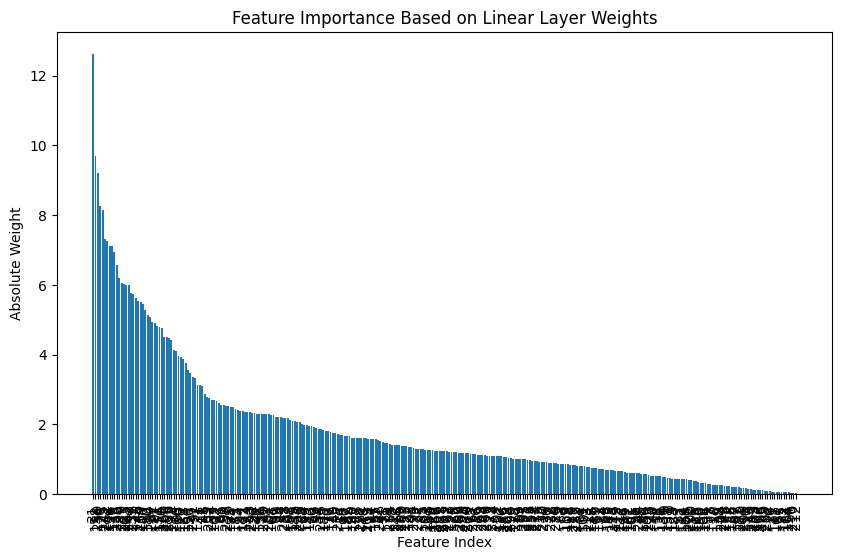

In [34]:
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
weights_np = weights.numpy().flatten()  # Flatten to 1D array

# Calculate the absolute values of the weights
abs_weights = np.abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_np)), abs_weights[top_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
plt.xticks(range(len(weights_np)), top_features, rotation=90)
plt.show()

In [35]:
weights = best_model.l1.weight.data.numpy()
abs_weights = np.abs(weights.flatten())

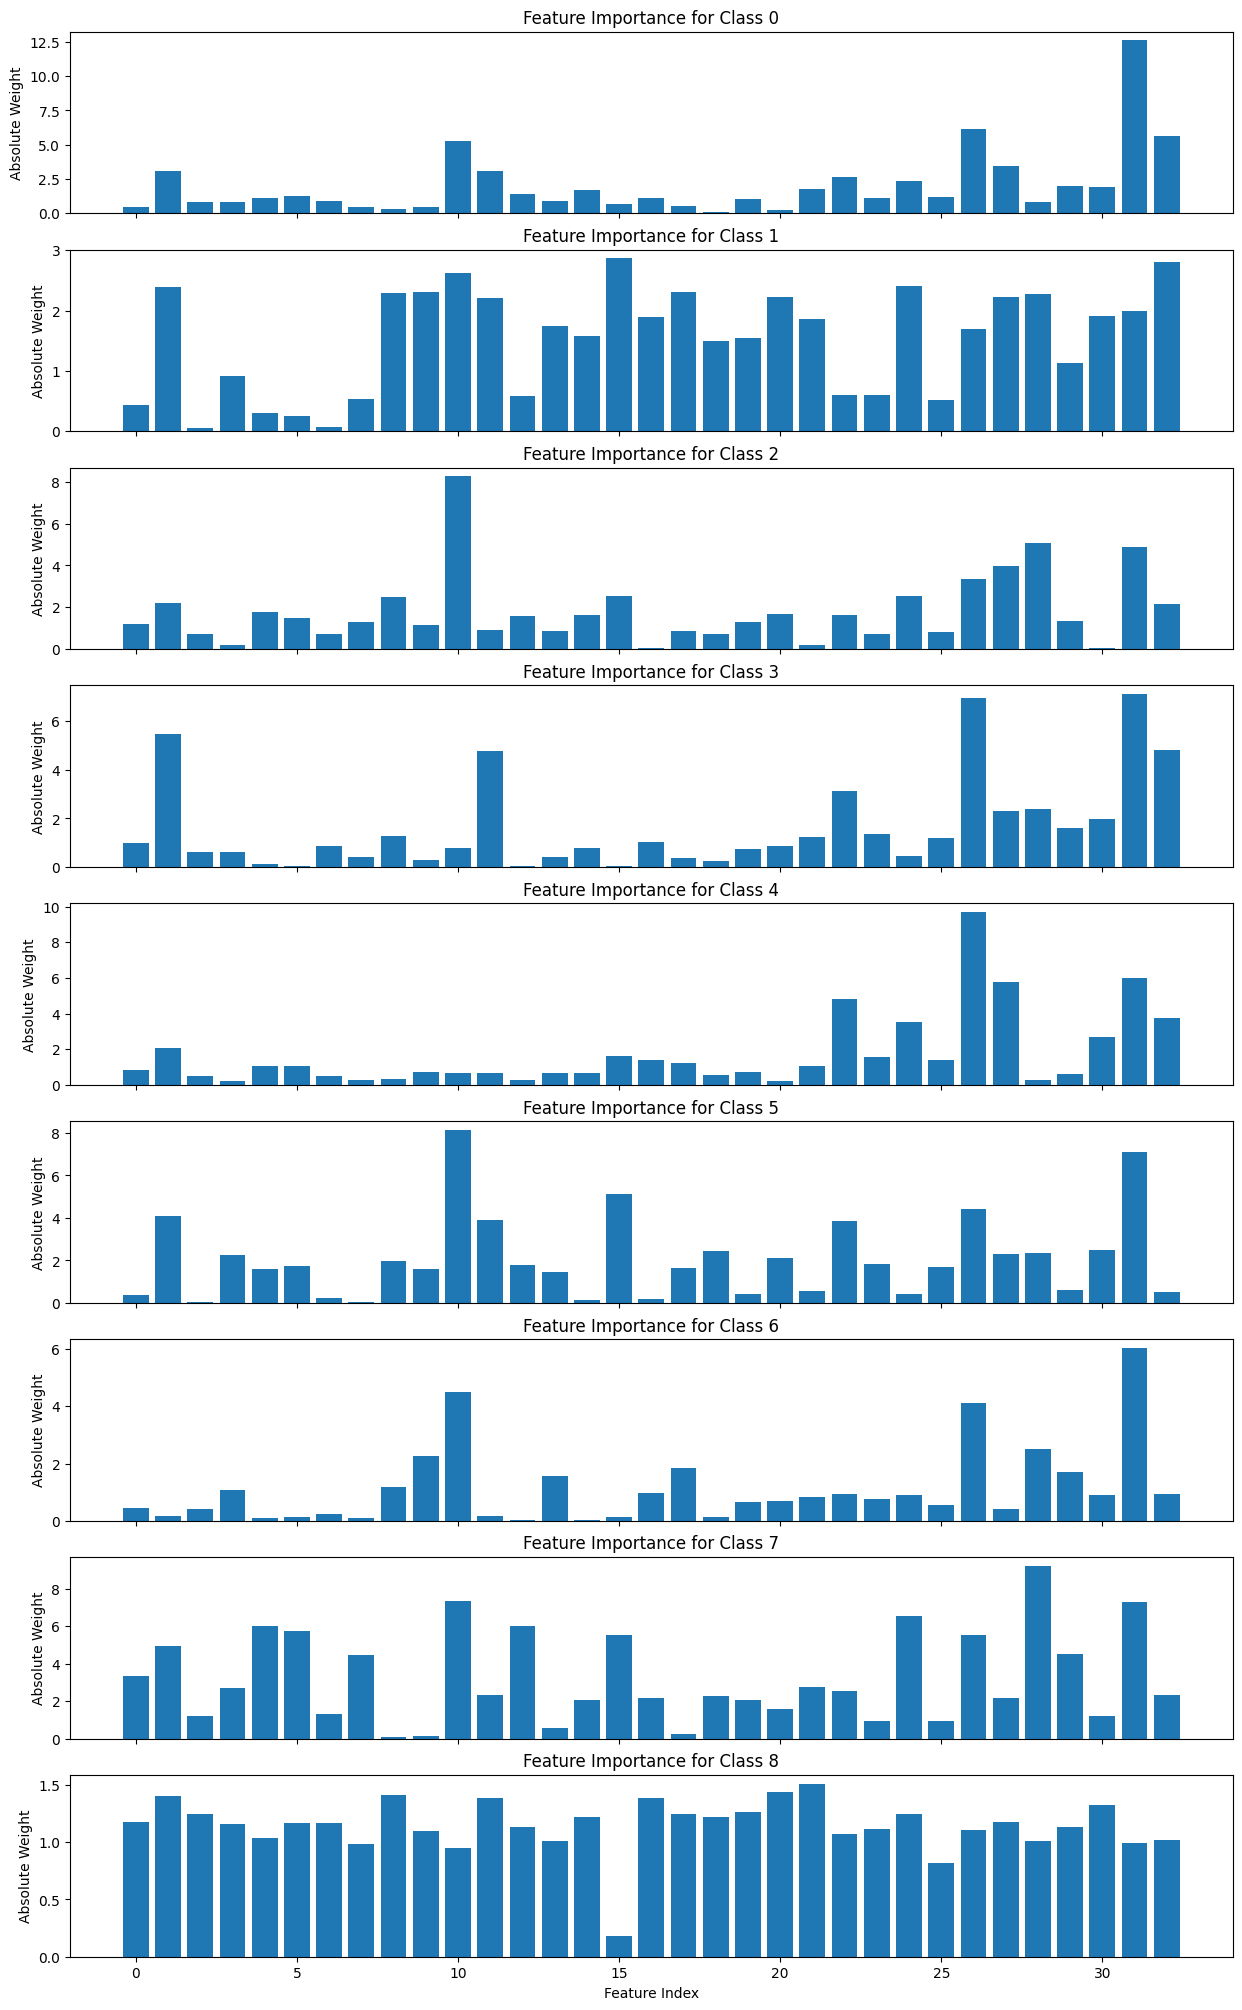

In [36]:
nrows = weights.shape[0]
xrows = weights.shape[1]

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 25), sharex=True)

for i in range(nrows):
    axes[i].bar(range(xrows), abs_weights[i*xrows:(i+1)*xrows])
    axes[i].set_title(f'Feature Importance for Class {i}')
    axes[i].set_ylabel('Absolute Weight')

plt.xlabel('Feature Index')
plt.show()

### Plotting Mean over Classes

In [37]:
from sklearn.preprocessing import minmax_scale

scaled_weights = minmax_scale(weights, axis=0)
weights_mean = np.abs(scaled_weights).mean(axis=0)

In [38]:
sorted_idx = weights_mean.argsort()[::-1]

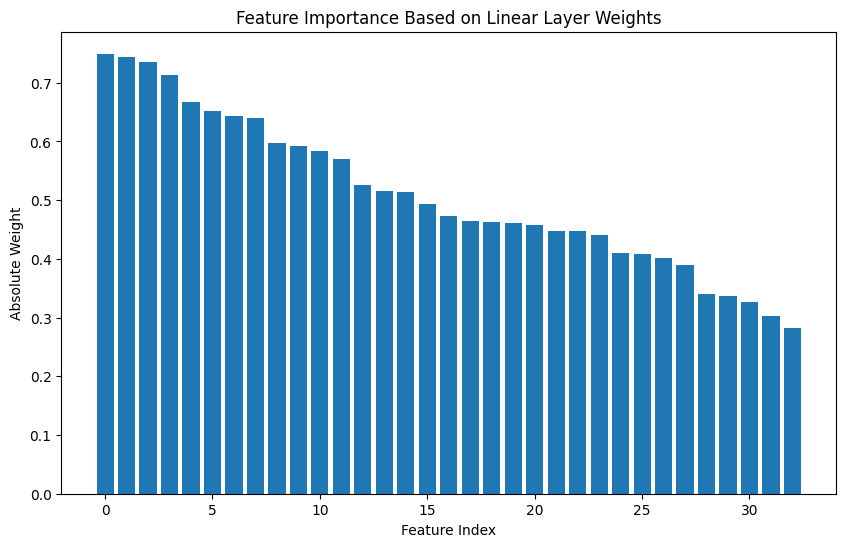

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx])), weights_mean[sorted_idx])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx, sorted_idx, rotation=90)
plt.show()

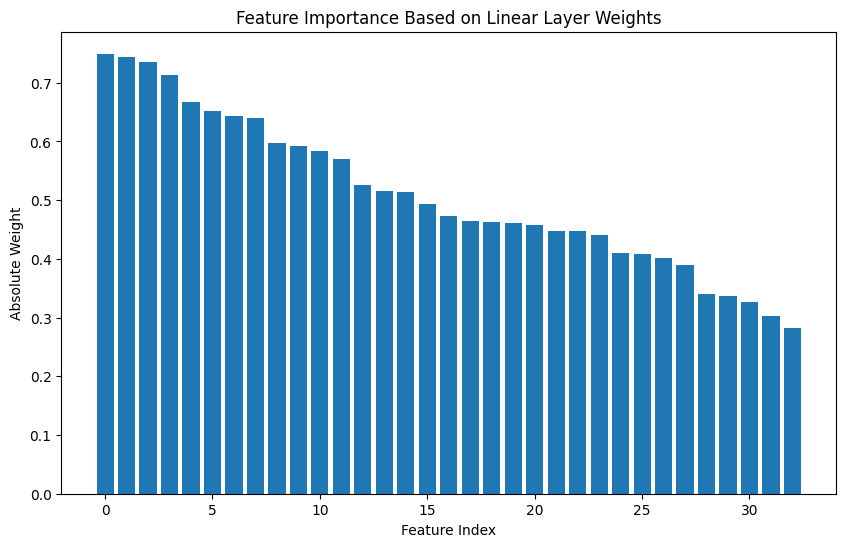

In [40]:
top_k = 50

plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx[:top_k]])), weights_mean[sorted_idx[:top_k]])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Plotting top k per class

In [41]:
topk = 4

In [42]:
topk_indices = weights.argpartition( -topk, axis=1)[:, -topk:]
topk_indices.shape

(9, 4)

In [43]:
topk_indices_sorted = np.take_along_axis(topk_indices, np.argsort(-weights[np.arange(weights.shape[0])[:, None], topk_indices]), axis=1)
topk_indices_sorted.shape

(9, 4)

In [44]:
selected_features = np.array(list(set(topk_indices_sorted.flatten())))
selected_features.shape

(23,)

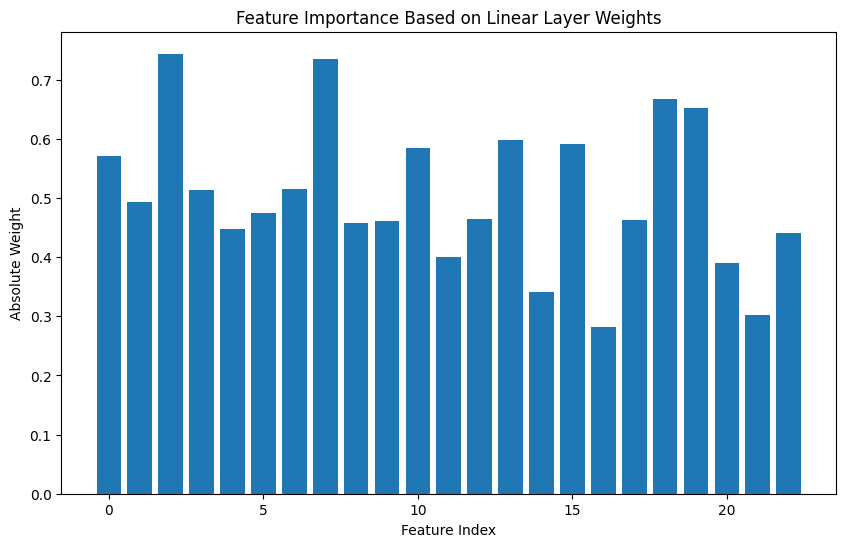

In [45]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[selected_features])), weights_mean[selected_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Train again

In [46]:
vectors.iloc[:,selected_features].shape

(20345, 23)

In [47]:
subset = vectors.iloc[:,selected_features]
subset["label"] = vectors["label"]

/tmp/ipykernel_43184/34610658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["label"] = vectors["label"]


In [48]:
# tensorboard = pl_loggers.TensorBoardLogger('./')

# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True) #logger=None, 


model = MalwaresModelLinearLayer(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [49]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 216   
------------------------------------------------------------
216       Trainable params
0         Non-trainable params
216       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,  12,   0,   0,   0,   0,  96,   0],
        [  0,   0,  33,   0,   0,   0,   0,  83,   0],
        [  0,   0,  24,   0,   0,   0,   0, 120,   0],
        [  0,   0,  10,   0,   0,   0,   0,  84,   0],
        [  0,   0,  21,   0,   0,   0,   0,  72,   0],
        [  0,   0,  12,   0,   0,   0,   0, 108,   0],
        [  0,   0,  11,   0,   0,   0,   0,  95,   0],
        [  0,   0,   3,   0,   0,   0,   0,  97,   0],
        [  0,   0,   0,   0,   0, 119,   0,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,    0, 1975,    0,    0,    0,    0,  146,    3],
        [   0, 1537,  624,    0,    0,    0,    0,  130,    0],
        [   0,    8, 3431,    0,    0,    0,    0,  199,    0],
        [   0,    0, 2040,    0,    0,    0,    0,  147,    0],
        [   0,    0, 2065,    0,    0,    0,    0,  128,    0],
        [   0,    1, 2062,    0,    0,    0,    0,  162,    0],
        [   0,    0, 2049,    0,    0,    0,    0,  145,    0],
        [   0,    0, 2070,    0,    0,    0,    0,  160,    0],
        [   0,    0,    0,    0,    0,  374,    0,    0, 1889]])


Metric Validation/Accuracy improved. New best score: 0.333


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,    0, 1975,    0,    0,    0,    0,  146,    3],
        [   0, 1537,  624,    0,    0,    0,    0,  130,    0],
        [   0,    8, 3431,    0,    0,    0,    0,  199,    0],
        [   0,    0, 2040,    0,    0,    0,    0,  147,    0],
        [   0,    0, 2065,    0,    0,    0,    0,  128,    0],
        [   0,    1, 2062,    0,    0,    0,    0,  162,    0],
        [   0,    0, 2049,    0,    0,    0,    0,  145,    0],
        [   0,    0, 2070,    0,    0,    0,    0,  160,    0],
        [   0,    0,    0,    0,    0,  374,    0,    0, 1889]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[   0,    0, 3988,    0,    0,    0,    0,  148,    4],
        [   0, 3711,  625,    0,    0,    0,    0,  130,    0],
        [   0,   21, 6912,    0,    0,    0,    0,  199,    0],
        [   0,    0, 4133,    0,    0,    0,    0,  147,    0],
        [   0,    0, 4159,    0,    6,    0,    0,  128,    0],
        [   0,    4, 4155,    0,    0,    2,    0,  169,    0],
        [   0,    0, 4137,    0,    0,    0,    0,  145,    0],
        [   0,    0, 4132,    0,    0,    0,    0,  228,    0],
        [   0,    0,    0,    0,    0,  374,    0,    0, 4033]])


Metric Validation/Accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.346


Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[   0,    0, 3988,    0,    0,    0,    0,  148,    4],
        [   0, 3711,  625,    0,    0,    0,    0,  130,    0],
        [   0,   21, 6912,    0,    0,    0,    0,  199,    0],
        [   0,    0, 4133,    0,    0,    0,    0,  147,    0],
        [   0,    0, 4159,    0,    6,    0,    0,  128,    0],
        [   0,    4, 4155,    0,    0,    2,    0,  169,    0],
        [   0,    0, 4137,    0,    0,    0,    0,  145,    0],
        [   0,    0, 4132,    0,    0,    0,    0,  228,    0],
        [   0,    0,    0,    0,    0,  374,    0,    0, 4033]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[    0,     0,  6001,     0,     0,     0,     0,   151,     4],
        [    0,  5886,   625,     0,     0,     0,     0,   130,     0],
        [    0,    37, 10389,     1,     0,     0,     0,   199,     0],
        [    0,     0,  6219,     7,     0,     0,     0,   147,     0],
        [    0,     0,  6188,     3,    69,     2,     0,   131,     0],
        [    0,     7,  6086,     0,     0,    53,     0,   289,     0],
        [    0,     0,  6219,     0,     2,     0,     0,   149,     0],
        [    0,     0,  5592,     0,     0,     1,     0,   897,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0,  6177]])


Metric Validation/Accuracy improved by 0.068 >= min_delta = 0.0. New best score: 0.414


Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[    0,     0,  6001,     0,     0,     0,     0,   151,     4],
        [    0,  5886,   625,     0,     0,     0,     0,   130,     0],
        [    0,    37, 10389,     1,     0,     0,     0,   199,     0],
        [    0,     0,  6219,     7,     0,     0,     0,   147,     0],
        [    0,     0,  6188,     3,    69,     2,     0,   131,     0],
        [    0,     7,  6086,     0,     0,    53,     0,   289,     0],
        [    0,     0,  6219,     0,     2,     0,     0,   149,     0],
        [    0,     0,  5592,     0,     0,     1,     0,   897,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0,  6177]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[    0,     0,  8013,     0,     0,     0,     0,   155,     4],
        [    0,  8061,   625,     0,     0,     0,     0,   130,     0],
        [    0,    50, 13858,     8,     1,     0,     0,   203,     0],
        [    0,     0,  8298,    19,     0,     2,     0,   147,     0],
        [    0,     0,  8128,     8,   200,     7,     0,   150,     0],
        [    0,    10,  7778,     0,     2,   239,     0,   511,     0],
        [    0,     0,  8288,     3,     4,     4,     0,   159,     0],
        [    0,     0,  6359,     0,     1,     4,     0,  2256,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0,  8321]])


Metric Validation/Accuracy improved by 0.025 >= min_delta = 0.0. New best score: 0.439


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[    0,     0,  8013,     0,     0,     0,     0,   155,     4],
        [    0,  8061,   625,     0,     0,     0,     0,   130,     0],
        [    0,    50, 13858,     8,     1,     0,     0,   203,     0],
        [    0,     0,  8298,    19,     0,     2,     0,   147,     0],
        [    0,     0,  8128,     8,   200,     7,     0,   150,     0],
        [    0,    10,  7778,     0,     2,   239,     0,   511,     0],
        [    0,     0,  8288,     3,     4,     4,     0,   159,     0],
        [    0,     0,  6359,     0,     1,     4,     0,  2256,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0,  8321]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[    7,     0,  9993,    17,     2,     2,     0,   163,     4],
        [    0, 10236,   625,     0,     0,     0,     0,   130,     0],
        [    1,    59, 17290,    18,    21,     4,     0,   221,     0],
        [    0,     0, 10333,    65,     5,     5,     0,   151,     0],
        [    0,     0,  9891,    18,   483,    22,     0,   179,     0],
        [    0,    10,  9082,     4,    31,   606,     0,   912,     0],
        [    0,     0, 10309,     7,    19,    18,     0,   193,     0],
        [    1,     0,  6653,    10,     5,     8,     0,  4073,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 10465]])


Metric Validation/Accuracy improved by 0.033 >= min_delta = 0.0. New best score: 0.472


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[    7,     0,  9993,    17,     2,     2,     0,   163,     4],
        [    0, 10236,   625,     0,     0,     0,     0,   130,     0],
        [    1,    59, 17290,    18,    21,     4,     0,   221,     0],
        [    0,     0, 10333,    65,     5,     5,     0,   151,     0],
        [    0,     0,  9891,    18,   483,    22,     0,   179,     0],
        [    0,    10,  9082,     4,    31,   606,     0,   912,     0],
        [    0,     0, 10309,     7,    19,    18,     0,   193,     0],
        [    1,     0,  6653,    10,     5,     8,     0,  4073,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 10465]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[   50,     0, 11930,    38,     3,     8,     0,   171,     4],
        [    0, 12411,   625,     0,     0,     0,     0,   130,     0],
        [   10,    67, 20696,    39,    37,    11,     0,   248,     0],
        [    4,     0, 12315,   154,    11,     9,     0,   159,     0],
        [    7,     0, 11502,    30,   883,    51,     0,   220,     0],
        [    7,    10, 10191,    10,    60,  1231,     0,  1241,     0],
        [   10,     0, 12309,    13,    31,    46,     0,   225,     0],
        [   10,     0,  6810,    17,     9,    13,     0,  6021,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 12609]])


Metric Validation/Accuracy improved by 0.020 >= min_delta = 0.0. New best score: 0.492


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[   50,     0, 11930,    38,     3,     8,     0,   171,     4],
        [    0, 12411,   625,     0,     0,     0,     0,   130,     0],
        [   10,    67, 20696,    39,    37,    11,     0,   248,     0],
        [    4,     0, 12315,   154,    11,     9,     0,   159,     0],
        [    7,     0, 11502,    30,   883,    51,     0,   220,     0],
        [    7,    10, 10191,    10,    60,  1231,     0,  1241,     0],
        [   10,     0, 12309,    13,    31,    46,     0,   225,     0],
        [   10,     0,  6810,    17,     9,    13,     0,  6021,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 12609]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[  127,     0, 13793,    82,     9,    18,     0,   187,     4],
        [    0, 14586,   625,     0,     0,     0,     0,   130,     0],
        [   25,    75, 24061,    83,    48,    32,     0,   278,     0],
        [   10,     0, 14220,   319,    18,    16,     0,   162,     0],
        [   20,     0, 12957,    56,  1394,    99,     0,   267,     0],
        [   16,    10, 11102,    37,   115,  2040,     0,  1535,     0],
        [   22,     0, 14277,    38,    46,    79,     0,   260,     0],
        [   21,     0,  6939,    28,    19,    17,     0,  7986,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 14753]])


Metric Validation/Accuracy improved by 0.022 >= min_delta = 0.0. New best score: 0.514


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[  127,     0, 13793,    82,     9,    18,     0,   187,     4],
        [    0, 14586,   625,     0,     0,     0,     0,   130,     0],
        [   25,    75, 24061,    83,    48,    32,     0,   278,     0],
        [   10,     0, 14220,   319,    18,    16,     0,   162,     0],
        [   20,     0, 12957,    56,  1394,    99,     0,   267,     0],
        [   16,    10, 11102,    37,   115,  2040,     0,  1535,     0],
        [   22,     0, 14277,    38,    46,    79,     0,   260,     0],
        [   21,     0,  6939,    28,    19,    17,     0,  7986,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 14753]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[  234,     0, 15595,   142,    23,    28,     0,   210,     4],
        [    0, 16761,   625,     0,     0,     0,     0,   130,     0],
        [   56,    83, 27397,   118,    68,    55,     0,   319,     0],
        [   36,     0, 16063,   509,    33,    23,     0,   174,     0],
        [   37,     0, 14297,    88,  1991,   155,     0,   325,     0],
        [   34,    10, 11803,    63,   193,  2958,     0,  1899,     0],
        [   44,     0, 16207,    67,    64,   118,     0,   310,     0],
        [   39,     0,  7006,    36,    24,    23,     0, 10012,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 16897]])


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.524


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[  234,     0, 15595,   142,    23,    28,     0,   210,     4],
        [    0, 16761,   625,     0,     0,     0,     0,   130,     0],
        [   56,    83, 27397,   118,    68,    55,     0,   319,     0],
        [   36,     0, 16063,   509,    33,    23,     0,   174,     0],
        [   37,     0, 14297,    88,  1991,   155,     0,   325,     0],
        [   34,    10, 11803,    63,   193,  2958,     0,  1899,     0],
        [   44,     0, 16207,    67,    64,   118,     0,   310,     0],
        [   39,     0,  7006,    36,    24,    23,     0, 10012,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 16897]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[  402,     0, 17305,   220,    40,    42,     0,   239,     4],
        [    0, 18935,   625,     0,     0,     1,     0,   130,     0],
        [  109,    91, 30682,   167,    95,    77,     0,   369,     0],
        [   88,     0, 17794,   780,    47,    28,     0,   194,     0],
        [   69,     0, 15568,   130,  2628,   211,     0,   387,     0],
        [   56,    10, 12417,    95,   277,  4019,     0,  2191,     0],
        [   73,     0, 18119,    97,    84,   166,     0,   359,     0],
        [   61,     0,  7065,    43,    30,    29,     0, 12042,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 19041]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[  402,     0, 17305,   220,    40,    42,     0,   239,     4],
        [    0, 18935,   625,     0,     0,     1,     0,   130,     0],
        [  109,    91, 30682,   167,    95,    77,     0,   369,     0],
        [   88,

Metric Validation/Accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.536


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[  606,     0, 18968,   297,    61,    63,     0,   269,     4],
        [    0, 21107,   625,     0,     0,     4,     0,   130,     0],
        [  176,    99, 33942,   210,   134,   115,     0,   408,     0],
        [  152,     0, 19501,  1054,    65,    46,     0,   206,     0],
        [  111,     0, 16731,   174,  3342,   299,     0,   436,     0],
        [   77,    10, 12852,   126,   370,  5355,     0,  2380,     0],
        [  113,     0, 20001,   133,   107,   233,     0,   399,     0],
        [   84,     0,  7121,    47,    36,    37,     0, 14075,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 21185]])


Metric Validation/Accuracy improved by 0.039 >= min_delta = 0.0. New best score: 0.575


Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[  606,     0, 18968,   297,    61,    63,     0,   269,     4],
        [    0, 21107,   625,     0,     0,     4,     0,   130,     0],
        [  176,    99, 33942,   210,   134,   115,     0,   408,     0],
        [  152,     0, 19501,  1054,    65,    46,     0,   206,     0],
        [  111,     0, 16731,   174,  3342,   299,     0,   436,     0],
        [   77,    10, 12852,   126,   370,  5355,     0,  2380,     0],
        [  113,     0, 20001,   133,   107,   233,     0,   399,     0],
        [   84,     0,  7121,    47,    36,    37,     0, 14075,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 21185]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[  901,     0, 20527,   381,    87,    83,     0,   301,     4],
        [    0, 23280,   625,     0,     0,     6,     0,   130,     0],
        [  267,   107, 37181,   267,   155,   151,     0,   450,     0],
        [  233,     0, 21139,  1371,    83,    63,     0,   228,     0],
        [  163,     0, 17788,   230,  4130,   391,     0,   491,     0],
        [  108,    10, 13230,   171,   470,  6690,     0,  2596,     0],
        [  163,     0, 21862,   171,   132,   302,     0,   444,     0],
        [  110,     0,  7154,    53,    43,    44,     0, 16126,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 23329]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.578


Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[  901,     0, 20527,   381,    87,    83,     0,   301,     4],
        [    0, 23280,   625,     0,     0,     6,     0,   130,     0],
        [  267,   107, 37181,   267,   155,   151,     0,   450,     0],
        [  233,     0, 21139,  1371,    83,    63,     0,   228,     0],
        [  163,     0, 17788,   230,  4130,   391,     0,   491,     0],
        [  108,    10, 13230,   171,   470,  6690,     0,  2596,     0],
        [  163,     0, 21862,   171,   132,   302,     0,   444,     0],
        [  110,     0,  7154,    53,    43,    44,     0, 16126,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 23329]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[ 1202,     0, 22030,   512,   113,   106,     0,   333,     4],
        [    0, 25452,   625,     0,     0,     9,     0,   130,     0],
        [  365,   115, 40373,   345,   178,   200,     0,   496,     0],
        [  311,     0, 22682,  1775,   101,    91,     0,   250,     0],
        [  213,     0, 18802,   307,  4925,   503,     0,   543,     0],
        [  129,    10, 13554,   221,   565,  8129,     0,  2772,     0],
        [  216,     0, 23682,   233,   155,   392,     0,   484,     0],
        [  137,     0,  7185,    60,    50,    51,     0, 18177,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 25473]])


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.585


Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[ 1202,     0, 22030,   512,   113,   106,     0,   333,     4],
        [    0, 25452,   625,     0,     0,     9,     0,   130,     0],
        [  365,   115, 40373,   345,   178,   200,     0,   496,     0],
        [  311,     0, 22682,  1775,   101,    91,     0,   250,     0],
        [  213,     0, 18802,   307,  4925,   503,     0,   543,     0],
        [  129,    10, 13554,   221,   565,  8129,     0,  2772,     0],
        [  216,     0, 23682,   233,   155,   392,     0,   484,     0],
        [  137,     0,  7185,    60,    50,    51,     0, 18177,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 25473]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[ 1554,     0, 23466,   646,   144,   129,     0,   373,     4],
        [    0, 27624,   625,     0,     0,    12,     0,   130,     0],
        [  481,   123, 43540,   433,   206,   244,     0,   539,     0],
        [  382,     0, 24202,  2209,   124,   113,     0,   273,     0],
        [  273,     0, 19757,   377,  5785,   609,     0,   592,     0],
        [  151,    10, 13864,   275,   672,  9556,     0,  2957,     0],
        [  275,     0, 25468,   297,   193,   485,     0,   532,     0],
        [  164,     0,  7213,    69,    56,    56,     0, 20232,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 27617]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.589


Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[ 1554,     0, 23466,   646,   144,   129,     0,   373,     4],
        [    0, 27624,   625,     0,     0,    12,     0,   130,     0],
        [  481,   123, 43540,   433,   206,   244,     0,   539,     0],
        [  382,     0, 24202,  2209,   124,   113,     0,   273,     0],
        [  273,     0, 19757,   377,  5785,   609,     0,   592,     0],
        [  151,    10, 13864,   275,   672,  9556,     0,  2957,     0],
        [  275,     0, 25468,   297,   193,   485,     0,   532,     0],
        [  164,     0,  7213,    69,    56,    56,     0, 20232,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 27617]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[ 1958,     0, 24830,   802,   171,   158,     1,   408,     4],
        [    0, 29796,   625,     0,     0,    15,     0,   130,     0],
        [  590,   131, 46711,   514,   239,   307,     3,   565,     0],
        [  463,     0, 25642,  2702,   150,   147,     0,   292,     0],
        [  332,     0, 20679,   461,  6653,   731,     0,   637,     0],
        [  174,    10, 14134,   343,   777, 11074,     0,  3078,     0],
        [  351,     0, 27219,   374,   221,   597,     0,   576,     0],
        [  191,     0,  7237,    79,    68,    65,     0, 22280,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 29761]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[ 1958,     0, 24830,   802,   171,   158,     1,   408,     4],
        [    0, 29796,   625,     0,     0,    15,     0,   130,     0],
        [  590,   131, 46711,   514,   239,   307,     3,   565,     0],
        [  46

Metric Validation/Accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.604


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[ 2369,     0, 26126,  1005,   204,   191,     1,   448,     4],
        [    0, 31968,   625,     0,     0,    18,     0,   130,     0],
        [  693,   139, 49819,   649,   281,   375,     3,   595,     0],
        [  545,     0, 27006,  3261,   183,   185,     0,   309,     0],
        [  387,     0, 21541,   573,  7561,   848,     0,   683,     0],
        [  198,    10, 14376,   420,   881, 12613,     0,  3197,     0],
        [  419,     0, 28920,   490,   262,   717,     1,   617,     0],
        [  218,     0,  7258,    90,    81,    73,     0, 24330,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 31905]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.612


Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[ 2369,     0, 26126,  1005,   204,   191,     1,   448,     4],
        [    0, 31968,   625,     0,     0,    18,     0,   130,     0],
        [  693,   139, 49819,   649,   281,   375,     3,   595,     0],
        [  545,     0, 27006,  3261,   183,   185,     0,   309,     0],
        [  387,     0, 21541,   573,  7561,   848,     0,   683,     0],
        [  198,    10, 14376,   420,   881, 12613,     0,  3197,     0],
        [  419,     0, 28920,   490,   262,   717,     1,   617,     0],
        [  218,     0,  7258,    90,    81,    73,     0, 24330,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 31905]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[ 2905,     0, 27388,  1133,   234,   216,     2,   482,     4],
        [    0, 34140,   625,     0,     0,    21,     0,   130,     0],
        [  852,   147, 52940,   731,   319,   444,     3,   612,     0],
        [  659,     0, 28400,  3763,   212,   222,     0,   326,     0],
        [  466,     0, 22400,   654,  8482,   963,     0,   728,     0],
        [  228,    10, 14615,   486,   997, 14169,     0,  3295,     0],
        [  529,     0, 30619,   559,   309,   840,     1,   657,     0],
        [  251,     0,  7277,    94,    95,    79,     0, 26384,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 34049]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[ 2905,     0, 27388,  1133,   234,   216,     2,   482,     4],
        [    0, 34140,   625,     0,     0,    21,     0,   130,     0],
        [  852,   147, 52940,   731,   319,   444,     3,   612,     0],
        [  65

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.615


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[ 3492,     0, 28570,  1275,   271,   247,     2,   519,     4],
        [    0, 36312,   625,     0,     0,    24,     0,   130,     0],
        [ 1010,   155, 56044,   820,   352,   518,     3,   640,     0],
        [  763,     0, 29706,  4351,   250,   262,     0,   343,     0],
        [  543,     0, 23196,   748,  9451,  1084,     0,   771,     0],
        [  261,    10, 14813,   564,  1110, 15738,     0,  3409,     0],
        [  642,     0, 32277,   650,   363,   971,     1,   698,     0],
        [  275,     0,  7293,   105,   109,    87,     0, 28441,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 36193]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[ 3492,     0, 28570,  1275,   271,   247,     2,   519,     4],
        [    0, 36312,   625,     0,     0,    24,     0,   130,     0],
        [ 1010,   155, 56044,   820,   352,   518,     3,   640,     0],
        [  76

Metric Validation/Accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.632


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[ 4143,     0, 29705,  1400,   309,   274,     4,   557,     4],
        [    0, 38484,   625,     0,     0,    27,     0,   130,     0],
        [ 1175,   163, 59133,   905,   402,   591,     5,   662,     0],
        [  910,     0, 31000,  4903,   293,   302,     0,   360,     0],
        [  630,     0, 23957,   837, 10450,  1206,     0,   813,     0],
        [  290,    10, 15013,   638,  1233, 17325,     0,  3501,     0],
        [  758,     0, 33934,   743,   415,  1098,     2,   740,     0],
        [  302,     0,  7308,   112,   124,    96,     0, 30498,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 38337]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[ 4143,     0, 29705,  1400,   309,   274,     4,   557,     4],
        [    0, 38484,   625,     0,     0,    27,     0,   130,     0],
        [ 1175,   163, 59133,   905,   402,   591,     5,   662,     0],
        [  91

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[ 4713,     0, 30872,  1570,   345,   311,     6,   591,     4],
        [    0, 40656,   625,     0,     0,    30,     0,   130,     0],
        [ 1316,   171, 62224,  1004,   449,   684,     5,   677,     0],
        [ 1019,     0, 32282,  5505,   334,   346,     0,   375,     0],
        [  707,     0, 24716,   937, 11442,  1346,     0,   845,     0],
        [  317,    10, 15176,   717,  1354, 18973,     0,  3568,     0],
        [  858,     0, 35573,   860,   468,  1233,     7,   779,     0],
        [  331,     0,  7320,   119,   138,   105,     0, 32557,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 40481]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[ 4713,     0, 30872,  1570,   345,   311,     6,   591,     4],
        [    0, 40656,   625,     0,     0,    30,     0,   130,     0],
        [ 1316,   171, 62224,  1004,   449,   684,     5,   677,     0],
        [ 101

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[ 5371,     0, 31968,  1720,   388,   339,    10,   628,     4],
        [    0, 42828,   625,     0,     0,    33,     0,   130,     0],
        [ 1480,   179, 65313,  1093,   497,   761,    11,   690,     0],
        [ 1138,     0, 33529,  6128,   375,   387,     2,   395,     0],
        [  780,     0, 25421,  1039, 12484,  1477,     6,   886,     0],
        [  344,    10, 15336,   795,  1484, 20608,     0,  3643,     0],
        [  971,     0, 37192,   975,   533,  1365,    14,   816,     0],
        [  360,     0,  7331,   125,   153,   113,     0, 34618,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 42625]])


Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.641


Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[ 5371,     0, 31968,  1720,   388,   339,    10,   628,     4],
        [    0, 42828,   625,     0,     0,    33,     0,   130,     0],
        [ 1480,   179, 65313,  1093,   497,   761,    11,   690,     0],
        [ 1138,     0, 33529,  6128,   375,   387,     2,   395,     0],
        [  780,     0, 25421,  1039, 12484,  1477,     6,   886,     0],
        [  344,    10, 15336,   795,  1484, 20608,     0,  3643,     0],
        [  971,     0, 37192,   975,   533,  1365,    14,   816,     0],
        [  360,     0,  7331,   125,   153,   113,     0, 34618,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 42625]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[ 6032,     0, 33038,  1893,   424,   386,    10,   657,     4],
        [    0, 45000,   625,     0,     0,    36,     0,   130,     0],
        [ 1627,   187, 68385,  1203,   552,   852,    13,   699,     0],
        [ 1259,     0, 34746,  6778,   415,   436,     2,   411,     0],
        [  861,     0, 26091,  1151, 13544,  1624,     7,   915,     0],
        [  368,    10, 15474,   882,  1607, 22278,     0,  3706,     0],
        [ 1079,     0, 38779,  1107,   600,  1526,    17,   846,     0],
        [  389,     0,  7341,   131,   169,   120,     0, 36680,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 44769]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[ 6032,     0, 33038,  1893,   424,   386,    10,   657,     4],
        [    0, 45000,   625,     0,     0,    36,     0,   130,     0],
        [ 1627,   187, 68385,  1203,   552,   852,    13,   699,     0],
        [ 125

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[ 6692,     0, 34107,  2064,   465,   423,    13,   692,     4],
        [    0, 47172,   625,     0,     0,    39,     0,   130,     0],
        [ 1783,   195, 71445,  1331,   602,   933,    18,   705,     0],
        [ 1365,     0, 35978,  7426,   461,   483,     3,   424,     0],
        [  937,     0, 26776,  1265, 14597,  1760,    12,   946,     0],
        [  391,    10, 15624,   961,  1730, 23951,     0,  3763,     0],
        [ 1185,     0, 40363,  1245,   669,  1678,    22,   880,     0],
        [  414,     0,  7352,   137,   188,   126,     0, 38743,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 46913]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[ 6692,     0, 34107,  2064,   465,   423,    13,   692,     4],
        [    0, 47172,   625,     0,     0,    39,     0,   130,     0],
        [ 1783,   195, 71445,  1331,   602,   933,    18,   705,     0],
        [ 136

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[ 7358,     0, 35151,  2257,   510,   457,    17,   722,     4],
        [    0, 49344,   625,     0,     0,    42,     0,   130,     0],
        [ 1925,   203, 74511,  1460,   664,  1011,    23,   709,     0],
        [ 1489,     0, 37166,  8096,   513,   525,     3,   441,     0],
        [ 1009,     0, 27434,  1383, 15674,  1902,    17,   974,     0],
        [  413,    10, 15760,  1054,  1862, 25620,     0,  3816,     0],
        [ 1280,     0, 41943,  1390,   751,  1828,    29,   909,     0],
        [  437,     0,  7362,   146,   206,   132,     0, 40807,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 49057]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[ 7358,     0, 35151,  2257,   510,   457,    17,   722,     4],
        [    0, 49344,   625,     0,     0,    42,     0,   130,     0],
        [ 1925,   203, 74511,  1460,   664,  1011,    23,   709,     0],
        [ 148

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[ 8100,     0, 36106,  2451,   560,   496,    19,   756,     4],
        [    0, 51516,   625,     0,     0,    45,     0,   130,     0],
        [ 2091,   211, 77537,  1592,   725,  1101,    28,   715,     0],
        [ 1610,     0, 38305,  8813,   567,   571,     4,   456,     0],
        [ 1085,     0, 28028,  1515, 16786,  2052,    25,  1002,     0],
        [  437,    10, 15862,  1146,  2000, 27323,     0,  3862,     0],
        [ 1390,     0, 43483,  1556,   825,  1989,    38,   937,     0],
        [  465,     0,  7371,   149,   224,   138,     0, 42873,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 51201]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[ 8100,     0, 36106,  2451,   560,   496,    19,   756,     4],
        [    0, 51516,   625,     0,     0,    45,     0,   130,     0],
        [ 2091,   211, 77537,  1592,   725,  1101,    28,   715,     0],
        [ 161

Metric Validation/Accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.658


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[ 8864,     0, 37043,  2644,   607,   537,    22,   787,     4],
        [    0, 53688,   625,     0,     0,    48,     0,   130,     0],
        [ 2266,   219, 80558,  1728,   782,  1185,    33,   723,     0],
        [ 1723,     0, 39434,  9552,   614,   616,     7,   473,     0],
        [ 1163,     0, 28634,  1651, 17888,  2201,    31,  1025,     0],
        [  462,    10, 15961,  1250,  2131, 29026,     0,  3905,     0],
        [ 1507,     0, 45027,  1714,   905,  2144,    42,   967,     0],
        [  493,     0,  7378,   155,   239,   145,     0, 44940,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 53345]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[ 8864,     0, 37043,  2644,   607,   537,    22,   787,     4],
        [    0, 53688,   625,     0,     0,    48,     0,   130,     0],
        [ 2266,   219, 80558,  1728,   782,  1185,    33,   723,     0],
        [ 172

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[ 9618,     0, 37985,  2842,   655,   578,    24,   818,     4],
        [    0, 55860,   625,     0,     0,    51,     0,   130,     0],
        [ 2430,   227, 83592,  1861,   845,  1270,    35,   728,     0],
        [ 1832,     0, 40566, 10292,   665,   661,     7,   489,     0],
        [ 1241,     0, 29229,  1781, 19015,  2343,    38,  1046,     0],
        [  491,    10, 16065,  1339,  2267, 30728,     0,  3950,     0],
        [ 1612,     0, 46564,  1885,   984,  2305,    50,   994,     0],
        [  517,     0,  7384,   161,   255,   151,     0, 47012,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 55489]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[ 9618,     0, 37985,  2842,   655,   578,    24,   818,     4],
        [    0, 55860,   625,     0,     0,    51,     0,   130,     0],
        [ 2430,   227, 83592,  1861,   845,  1270,    35,   728,     0],
        [ 183

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[10424,     0, 38881,  3026,   708,   612,    34,   851,     4],
        [    0, 58032,   625,     0,     0,    54,     0,   130,     0],
        [ 2599,   235, 86617,  1991,   919,  1349,    41,   731,     0],
        [ 1948,     0, 41696, 11011,   726,   712,    12,   500,     0],
        [ 1316,     0, 29791,  1915, 20157,  2493,    54,  1067,     0],
        [  516,    10, 16155,  1425,  2404, 32459,     1,  3985,     0],
        [ 1730,     0, 48076,  2044,  1077,  2477,    61,  1017,     0],
        [  538,     0,  7390,   170,   272,   159,     0, 49081,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 57633]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[10424,     0, 38881,  3026,   708,   612,    34,   851,     4],
        [    0, 58032,   625,     0,     0,    54,     0,   130,     0],
        [ 2599,   235, 86617,  1991,   919,  1349,    41,   731,     0],
        [ 194

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.660


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[11257,     0, 39729,  3223,   762,   652,    44,   885,     4],
        [    0, 60204,   625,     0,     0,    57,     0,   130,     0],
        [ 2772,   243, 89606,  2145,   997,  1431,    49,   733,     0],
        [ 2051,     0, 42766, 11800,   787,   762,    17,   515,     0],
        [ 1392,     0, 30350,  2054, 21313,  2629,    68,  1087,     0],
        [  538,    10, 16252,  1519,  2549, 34168,     2,  4022,     0],
        [ 1848,     0, 49557,  2232,  1168,  2646,    76,  1043,     0],
        [  560,     0,  7397,   178,   290,   167,     0, 51148,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 59777]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.663


Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[11257,     0, 39729,  3223,   762,   652,    44,   885,     4],
        [    0, 60204,   625,     0,     0,    57,     0,   130,     0],
        [ 2772,   243, 89606,  2145,   997,  1431,    49,   733,     0],
        [ 2051,     0, 42766, 11800,   787,   762,    17,   515,     0],
        [ 1392,     0, 30350,  2054, 21313,  2629,    68,  1087,     0],
        [  538,    10, 16252,  1519,  2549, 34168,     2,  4022,     0],
        [ 1848,     0, 49557,  2232,  1168,  2646,    76,  1043,     0],
        [  560,     0,  7397,   178,   290,   167,     0, 51148,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 59777]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[12083,     0, 40579,  3429,   812,   694,    54,   917,     4],
        [    0, 62376,   625,     0,     0,    60,     0,   130,     0],
        [ 2941,   243, 92623,  2294,  1060,  1509,    63,   737,     0],
        [ 2156,     0, 43845, 12583,   846,   816,    22,   523,     0],
        [ 1468,     0, 30902,  2193, 22469,  2776,    79,  1106,     0],
        [  559,    10, 16338,  1614,  2679, 35900,     4,  4061,     0],
        [ 1957,     0, 51067,  2409,  1247,  2822,    91,  1065,     0],
        [  581,     0,  7403,   187,   306,   173,     0, 53220,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 61921]])


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.669


Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[12083,     0, 40579,  3429,   812,   694,    54,   917,     4],
        [    0, 62376,   625,     0,     0,    60,     0,   130,     0],
        [ 2941,   243, 92623,  2294,  1060,  1509,    63,   737,     0],
        [ 2156,     0, 43845, 12583,   846,   816,    22,   523,     0],
        [ 1468,     0, 30902,  2193, 22469,  2776,    79,  1106,     0],
        [  559,    10, 16338,  1614,  2679, 35900,     4,  4061,     0],
        [ 1957,     0, 51067,  2409,  1247,  2822,    91,  1065,     0],
        [  581,     0,  7403,   187,   306,   173,     0, 53220,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 61921]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[12964,     0, 41401,  3610,   864,   735,    64,   946,     4],
        [    0, 64548,   625,     0,     0,    63,     0,   130,     0],
        [ 3118,   243, 95627,  2444,  1131,  1588,    73,   740,     0],
        [ 2285,     0, 44908, 13342,   912,   869,    32,   536,     0],
        [ 1551,     0, 31428,  2333, 23630,  2931,    93,  1127,     0],
        [  583,    10, 16426,  1701,  2813, 37636,     5,  4096,     0],
        [ 2093,     0, 52535,  2583,  1336,  2999,   113,  1087,     0],
        [  605,     0,  7410,   194,   322,   179,     0, 55290,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 64065]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[12964,     0, 41401,  3610,   864,   735,    64,   946,     4],
        [    0, 64548,   625,     0,     0,    63,     0,   130,     0],
        [ 3118,   243, 95627,  2444,  1131,  1588,    73,   740,     0],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[13873,     0, 42237,  3763,   913,   775,    72,   967,     4],
        [    0, 66720,   625,     0,     0,    66,     0,   130,     0],
        [ 3301,   243, 98654,  2566,  1204,  1665,    81,   744,     0],
        [ 2434,     0, 46004, 14063,   970,   925,    35,   546,     0],
        [ 1640,     0, 31980,  2459, 24774,  3090,   105,  1145,     0],
        [  611,    10, 16501,  1790,  2936, 39386,     5,  4136,     0],
        [ 2234,     0, 54040,  2734,  1415,  3177,   126,  1108,     0],
        [  628,     0,  7416,   200,   340,   186,     0, 57360,     0],
        [    0,     0,     0,     0,     0,   374,     0,     0, 66209]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[13873,     0, 42237,  3763,   913,   775,    72,   967,     4],
        [    0, 66720,   625,     0,     0,    66,     0,   130,     0],
        [ 3301,   243, 98654,  2566,  1204,  1665,    81,   744,     0],
        [ 243

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[ 14801,      0,  43033,   3933,    963,    815,     80,    991,      4],
        [     0,  68892,    625,      0,      0,     69,      0,    130,      0],
        [  3486,    243, 101644,   2719,   1275,   1745,     93,    747,      0],
        [  2544,      0,  47054,  14860,   1036,    975,     48,    553,      0],
        [  1710,      0,  32504,   2610,  25946,   3241,    122,   1160,      0],
        [   628,     10,  16582,   1884,   3061,  41141,      5,   4169,      0],
        [  2352,      0,  55508,   2916,   1507,   3369,    145,   1125,      0],
        [   650,      0,   7422,    208,    358,    193,      0,  59429,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  68353]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.670


Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[ 14801,      0,  43033,   3933,    963,    815,     80,    991,      4],
        [     0,  68892,    625,      0,      0,     69,      0,    130,      0],
        [  3486,    243, 101644,   2719,   1275,   1745,     93,    747,      0],
        [  2544,      0,  47054,  14860,   1036,    975,     48,    553,      0],
        [  1710,      0,  32504,   2610,  25946,   3241,    122,   1160,      0],
        [   628,     10,  16582,   1884,   3061,  41141,      5,   4169,      0],
        [  2352,      0,  55508,   2916,   1507,   3369,    145,   1125,      0],
        [   650,      0,   7422,    208,    358,    193,      0,  59429,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  68353]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[ 15701,      0,  43832,   4116,   1020,    849,     94,   1020,      4],
        [     0,  71064,    625,      0,      0,     72,      0,    130,      0],
        [  3663,    243, 104641,   2873,   1355,   1810,    112,    749,      0],
        [  2659,      0,  48105,  15652,   1103,   1024,     57,    563,      0],
        [  1785,      0,  33027,   2759,  27124,   3389,    136,   1173,      0],
        [   646,     10,  16659,   1974,   3193,  42893,      8,   4202,      0],
        [  2467,      0,  56989,   3097,   1595,   3552,    166,   1144,      0],
        [   674,      0,   7428,    214,    374,    199,      0,  61501,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  70497]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[ 15701,      0,  43832,   4116,   1020,    849,     94,   1020,      4],
        [     0,  71064,    625,      0,      0,     72,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[ 16584,      0,  44635,   4320,   1072,    884,    108,   1045,      4],
        [     0,  73236,    625,      0,      0,     75,      0,    130,      0],
        [  3818,    243, 107627,   3054,   1436,   1885,    125,    752,      0],
        [  2765,      0,  49129,  16474,   1169,   1073,     71,    575,      0],
        [  1856,      0,  33520,   2912,  28326,   3540,    154,   1185,      0],
        [   663,     10,  16728,   2067,   3328,  44655,      8,   4231,      0],
        [  2568,      0,  58456,   3295,   1693,   3728,    196,   1162,      0],
        [   696,      0,   7434,    219,    394,    205,      0,  63572,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  72641]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[ 16584,      0,  44635,   4320,   1072,    884,    108,   1045,      4],
        [     0,  73236,    625,      0,      0,     75,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[ 17479,      0,  45454,   4511,   1120,    919,    114,   1067,      4],
        [     0,  75408,    625,      0,      0,     78,      0,    130,      0],
        [  3986,    243, 110640,   3206,   1511,   1956,    136,    756,      0],
        [  2862,      0,  50187,  17282,   1228,   1126,     83,    581,      0],
        [  1920,      0,  34043,   3060,  29515,   3684,    173,   1198,      0],
        [   675,     10,  16802,   2158,   3460,  46422,      9,   4259,      0],
        [  2673,      0,  59938,   3491,   1782,   3903,    220,   1179,      0],
        [   717,      0,   7440,    228,    410,    211,      0,  65644,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  74785]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[ 17479,      0,  45454,   4511,   1120,    919,    114,   1067,      4],
        [     0,  75408,    625,      0,      0,     78,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[ 18422,      0,  46215,   4701,   1177,    954,    123,   1088,      4],
        [     0,  77580,    625,      0,      0,     81,      0,    130,      0],
        [  4155,    243, 113636,   3361,   1595,   2033,    148,    757,      0],
        [  2968,      0,  51212,  18107,   1293,   1178,     94,    590,      0],
        [  1989,      0,  34536,   3215,  30730,   3831,    183,   1209,      0],
        [   687,     10,  16870,   2248,   3594,  48194,     11,   4286,      0],
        [  2788,      0,  61397,   3697,   1882,   4079,    234,   1197,      0],
        [   737,      0,   7446,    237,    427,    217,      0,  67716,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  76929]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.672


Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[ 18422,      0,  46215,   4701,   1177,    954,    123,   1088,      4],
        [     0,  77580,    625,      0,      0,     81,      0,    130,      0],
        [  4155,    243, 113636,   3361,   1595,   2033,    148,    757,      0],
        [  2968,      0,  51212,  18107,   1293,   1178,     94,    590,      0],
        [  1989,      0,  34536,   3215,  30730,   3831,    183,   1209,      0],
        [   687,     10,  16870,   2248,   3594,  48194,     11,   4286,      0],
        [  2788,      0,  61397,   3697,   1882,   4079,    234,   1197,      0],
        [   737,      0,   7446,    237,    427,    217,      0,  67716,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  76929]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[ 19371,      0,  46945,   4912,   1235,    992,    132,   1109,      4],
        [     0,  79752,    625,      0,      0,     84,      0,    130,      0],
        [  4328,    243, 116629,   3531,   1670,   2103,    160,    758,      0],
        [  3064,      0,  52204,  18956,   1373,   1229,    113,    596,      0],
        [  2060,      0,  35005,   3374,  31951,   3985,    198,   1220,      0],
        [   699,     10,  16932,   2338,   3724,  49977,     11,   4314,      0],
        [  2897,      0,  62824,   3919,   1985,   4266,    258,   1213,      0],
        [   754,      0,   7452,    244,    448,    223,      0,  69789,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  79073]])


Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.682


Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[ 19371,      0,  46945,   4912,   1235,    992,    132,   1109,      4],
        [     0,  79752,    625,      0,      0,     84,      0,    130,      0],
        [  4328,    243, 116629,   3531,   1670,   2103,    160,    758,      0],
        [  3064,      0,  52204,  18956,   1373,   1229,    113,    596,      0],
        [  2060,      0,  35005,   3374,  31951,   3985,    198,   1220,      0],
        [   699,     10,  16932,   2338,   3724,  49977,     11,   4314,      0],
        [  2897,      0,  62824,   3919,   1985,   4266,    258,   1213,      0],
        [   754,      0,   7452,    244,    448,    223,      0,  69789,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  79073]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[ 20399,      0,  47646,   5082,   1287,   1030,    141,   1127,      4],
        [     0,  81924,    625,      0,      0,     87,      0,    130,      0],
        [  4512,    243, 119613,   3694,   1748,   2174,    173,    759,      0],
        [  3175,      0,  53195,  19805,   1439,   1284,    128,    602,      0],
        [  2134,      0,  35467,   3534,  33176,   4138,    213,   1231,      0],
        [   711,     10,  16994,   2426,   3853,  51761,     13,   4342,      0],
        [  3030,      0,  64257,   4127,   2084,   4442,    279,   1231,      0],
        [   778,      0,   7458,    251,    465,    229,      0,  71859,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  81217]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.683


Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[ 20399,      0,  47646,   5082,   1287,   1030,    141,   1127,      4],
        [     0,  81924,    625,      0,      0,     87,      0,    130,      0],
        [  4512,    243, 119613,   3694,   1748,   2174,    173,    759,      0],
        [  3175,      0,  53195,  19805,   1439,   1284,    128,    602,      0],
        [  2134,      0,  35467,   3534,  33176,   4138,    213,   1231,      0],
        [   711,     10,  16994,   2426,   3853,  51761,     13,   4342,      0],
        [  3030,      0,  64257,   4127,   2084,   4442,    279,   1231,      0],
        [   778,      0,   7458,    251,    465,    229,      0,  71859,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  81217]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[ 21372,      0,  48363,   5287,   1341,   1068,    154,   1143,      4],
        [     0,  84096,    625,      0,      0,     90,      0,    130,      0],
        [  4674,    243, 122607,   3864,   1836,   2239,    186,    761,      0],
        [  3272,      0,  54197,  20659,   1507,   1335,    143,    608,      0],
        [  2200,      0,  35925,   3694,  34423,   4278,    232,   1241,      0],
        [   721,     10,  17060,   2515,   3983,  53541,     16,   4369,      0],
        [  3137,      0,  65691,   4346,   2187,   4624,    304,   1249,      0],
        [   797,      0,   7464,    259,    482,    235,      0,  73933,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  83361]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[ 21372,      0,  48363,   5287,   1341,   1068,    154,   1143,      4],
        [     0,  84096,    625,      0,      0,     90,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[ 22342,      0,  49081,   5493,   1395,   1106,    166,   1161,      4],
        [     0,  86268,    625,      0,      0,     93,      0,    130,      0],
        [  4830,    243, 125599,   4045,   1918,   2306,    202,    761,      0],
        [  3360,      0,  55175,  21538,   1577,   1388,    162,    614,      0],
        [  2270,      0,  36376,   3857,  35673,   4418,    250,   1249,      0],
        [   733,     10,  17123,   2605,   4115,  55323,     17,   4394,      0],
        [  3253,      0,  67114,   4562,   2296,   4809,    328,   1264,      0],
        [   815,      0,   7470,    267,    502,    241,      0,  76005,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  85505]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[ 22342,      0,  49081,   5493,   1395,   1106,    166,   1161,      4],
        [     0,  86268,    625,      0,      0,     93,      0,    1

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.687


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[ 23396,      0,  49740,   5684,   1449,   1136,    176,   1179,      4],
        [     0,  88440,    625,      0,      0,     96,      0,    130,      0],
        [  5020,    243, 128559,   4215,   2000,   2375,    224,    762,      0],
        [  3468,      0,  56143,  22405,   1647,   1444,    180,    620,      0],
        [  2344,      0,  36822,   4024,  36914,   4561,    271,   1257,      0],
        [   746,     10,  17181,   2695,   4246,  57107,     20,   4420,      0],
        [  3374,      0,  68511,   4790,   2407,   4993,    358,   1281,      0],
        [   834,      0,   7476,    274,    520,    247,      0,  78079,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  87649]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.689


Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[ 23396,      0,  49740,   5684,   1449,   1136,    176,   1179,      4],
        [     0,  88440,    625,      0,      0,     96,      0,    130,      0],
        [  5020,    243, 128559,   4215,   2000,   2375,    224,    762,      0],
        [  3468,      0,  56143,  22405,   1647,   1444,    180,    620,      0],
        [  2344,      0,  36822,   4024,  36914,   4561,    271,   1257,      0],
        [   746,     10,  17181,   2695,   4246,  57107,     20,   4420,      0],
        [  3374,      0,  68511,   4790,   2407,   4993,    358,   1281,      0],
        [   834,      0,   7476,    274,    520,    247,      0,  78079,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  87649]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[ 24419,      0,  50418,   5880,   1506,   1173,    185,   1195,      4],
        [     0,  90612,    625,      0,      0,     99,      0,    130,      0],
        [  5178,    243, 131522,   4409,   2093,   2442,    242,    763,      0],
        [  3568,      0,  57113,  23268,   1728,   1496,    201,    626,      0],
        [  2413,      0,  37276,   4188,  38156,   4699,    295,   1266,      0],
        [   758,     10,  17236,   2780,   4381,  58897,     22,   4446,      0],
        [  3489,      0,  69922,   5007,   2521,   5182,    388,   1293,      0],
        [   854,      0,   7482,    280,    537,    253,      0,  80154,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  89793]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[ 24419,      0,  50418,   5880,   1506,   1173,    185,   1195,      4],
        [     0,  90612,    625,      0,      0,     99,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[ 25432,      0,  51093,   6084,   1565,   1214,    194,   1210,      4],
        [     0,  92786,    625,      0,      0,    100,      0,    130,      0],
        [  5335,    243, 134490,   4595,   2186,   2509,    265,    763,      0],
        [  3656,      0,  58069,  24161,   1802,   1549,    223,    633,      0],
        [  2480,      0,  37721,   4355,  39409,   4842,    312,   1274,      0],
        [   767,     10,  17291,   2868,   4515,  60690,     25,   4469,      0],
        [  3592,      0,  71335,   5244,   2625,   5370,    418,   1306,      0],
        [   873,      0,   7488,    286,    555,    259,      0,  82229,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  91937]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[ 25432,      0,  51093,   6084,   1565,   1214,    194,   1210,      4],
        [     0,  92786,    625,      0,      0,    100,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[ 26471,      0,  51761,   6270,   1624,   1253,    203,   1226,      4],
        [     0,  94960,    625,      0,      0,    101,      0,    130,      0],
        [  5503,    243, 137459,   4776,   2275,   2574,    286,    764,      0],
        [  3754,      0,  59024,  25035,   1884,   1607,    244,    638,      0],
        [  2544,      0,  38162,   4514,  40672,   4987,    335,   1279,      0],
        [   779,     10,  17349,   2950,   4643,  62487,     28,   4494,      0],
        [  3705,      0,  72738,   5463,   2741,   5565,    448,   1318,      0],
        [   891,      0,   7494,    292,    572,    265,      0,  84306,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  94081]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[ 26471,      0,  51761,   6270,   1624,   1253,    203,   1226,      4],
        [     0,  94960,    625,      0,      0,    101,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[ 27527,      0,  52438,   6441,   1680,   1284,    213,   1241,      4],
        [     0,  97133,    625,      0,      0,    103,      0,    130,      0],
        [  5668,    243, 140441,   4946,   2371,   2632,    308,    765,      0],
        [  3846,      0,  59999,  25910,   1959,   1658,    263,    644,      0],
        [  2609,      0,  38610,   4681,  41930,   5123,    358,   1282,      0],
        [   791,     10,  17411,   3036,   4771,  64275,     32,   4519,      0],
        [  3812,      0,  74165,   5681,   2853,   5742,    481,   1332,      0],
        [   910,      0,   7499,    298,    586,    271,      0,  86386,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  96225]])
Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[ 27527,      0,  52438,   6441,   1680,   1284,    213,   1241,      4],
        [     0,  97133,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[ 28586,      0,  53089,   6630,   1733,   1320,    225,   1257,      4],
        [     0,  99308,    625,      0,      0,    103,      0,    130,      0],
        [  5841,    243, 143406,   5131,   2449,   2690,    341,    767,      0],
        [  3932,      0,  60956,  26802,   2036,   1710,    286,    650,      0],
        [  2680,      0,  39048,   4850,  43180,   5266,    384,   1285,      0],
        [   800,     10,  17467,   3120,   4895,  66077,     36,   4545,      0],
        [  3919,      0,  75577,   5906,   2960,   5923,    521,   1348,      0],
        [   930,      0,   7505,    304,    601,    277,      0,  88463,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  98369]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.696


Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[ 28586,      0,  53089,   6630,   1733,   1320,    225,   1257,      4],
        [     0,  99308,    625,      0,      0,    103,      0,    130,      0],
        [  5841,    243, 143406,   5131,   2449,   2690,    341,    767,      0],
        [  3932,      0,  60956,  26802,   2036,   1710,    286,    650,      0],
        [  2680,      0,  39048,   4850,  43180,   5266,    384,   1285,      0],
        [   800,     10,  17467,   3120,   4895,  66077,     36,   4545,      0],
        [  3919,      0,  75577,   5906,   2960,   5923,    521,   1348,      0],
        [   930,      0,   7505,    304,    601,    277,      0,  88463,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0,  98369]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[ 29706,      0,  53706,   6800,   1786,   1351,    236,   1271,      4],
        [     0, 101483,    625,      0,      0,    103,      0,    130,      0],
        [  6020,    243, 146352,   5318,   2537,   2751,    374,    767,      0],
        [  4031,      0,  61885,  27703,   2116,   1762,    312,    656,      0],
        [  2748,      0,  39475,   5029,  44449,   5399,    404,   1289,      0],
        [   809,     10,  17523,   3204,   5021,  67883,     40,   4565,      0],
        [  4029,      0,  76973,   6141,   3075,   6107,    557,   1360,      0],
        [   950,      0,   7511,    310,    615,    283,      0,  90541,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 100513]])
Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[ 29706,      0,  53706,   6800,   1786,   1351,    236,   1271,      4],
        [     0, 101483,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[ 30780,      0,  54351,   6974,   1844,   1384,    253,   1286,      4],
        [     0, 103658,    625,      0,      0,    103,      0,    130,      0],
        [  6179,    243, 149300,   5507,   2631,   2809,    420,    767,      0],
        [  4135,      0,  62856,  28554,   2193,   1816,    342,    662,      0],
        [  2817,      0,  39907,   5191,  45717,   5539,    430,   1292,      0],
        [   818,     10,  17579,   3280,   5145,  69698,     43,   4587,      0],
        [  4131,      0,  78385,   6365,   3184,   6284,    609,   1372,      0],
        [   967,      0,   7514,    316,    632,    289,      0,  92622,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 102657]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[ 30780,      0,  54351,   6974,   1844,   1384,    253,   1286,      4],
        [     0, 103658,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[ 31851,      0,  54990,   7166,   1900,   1416,    264,   1301,      4],
        [     0, 105833,    625,      0,      0,    103,      0,    130,      0],
        [  6338,    243, 152264,   5696,   2723,   2871,    448,    767,      0],
        [  4225,      0,  63790,  29463,   2269,   1871,    365,    668,      0],
        [  2880,      0,  40349,   5364,  46976,   5680,    450,   1294,      0],
        [   827,     10,  17635,   3356,   5268,  71512,     48,   4609,      0],
        [  4232,      0,  79788,   6605,   3300,   6465,    646,   1382,      0],
        [   982,      0,   7519,    322,    648,    295,      0,  94704,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 104801]])
Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[ 31851,      0,  54990,   7166,   1900,   1416,    264,   1301,      4],
        [     0, 105833,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[ 32970,      0,  55579,   7353,   1960,   1448,    280,   1314,      4],
        [     0, 108008,    625,      0,      0,    103,      0,    130,      0],
        [  6513,    243, 155201,   5886,   2821,   2929,    483,    768,      0],
        [  4317,      0,  64687,  30390,   2345,   1926,    405,    674,      0],
        [  2943,      0,  40751,   5544,  48255,   5818,    486,   1296,      0],
        [   836,     10,  17684,   3441,   5394,  73316,     56,   4633,      0],
        [  4332,      0,  81145,   6853,   3416,   6650,    717,   1393,      0],
        [   997,      0,   7524,    328,    665,    301,      0,  96785,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 106945]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.703


Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[ 32970,      0,  55579,   7353,   1960,   1448,    280,   1314,      4],
        [     0, 108008,    625,      0,      0,    103,      0,    130,      0],
        [  6513,    243, 155201,   5886,   2821,   2929,    483,    768,      0],
        [  4317,      0,  64687,  30390,   2345,   1926,    405,    674,      0],
        [  2943,      0,  40751,   5544,  48255,   5818,    486,   1296,      0],
        [   836,     10,  17684,   3441,   5394,  73316,     56,   4633,      0],
        [  4332,      0,  81145,   6853,   3416,   6650,    717,   1393,      0],
        [   997,      0,   7524,    328,    665,    301,      0,  96785,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 106945]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[ 34073,      0,  56182,   7543,   2019,   1482,    293,   1328,      4],
        [     0, 110183,    625,      0,      0,    103,      0,    130,      0],
        [  6661,    243, 158154,   6085,   2922,   2988,    517,    768,      0],
        [  4415,      0,  65592,  31310,   2429,   1981,    430,    680,      0],
        [  3001,      0,  41157,   5723,  49549,   5953,    512,   1298,      0],
        [   845,     10,  17733,   3521,   5524,  75125,     61,   4656,      0],
        [  4435,      0,  82513,   7099,   3545,   6835,    764,   1403,      0],
        [  1010,      0,   7530,    334,    682,    307,      0,  98867,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 109089]])
Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[ 34073,      0,  56182,   7543,   2019,   1482,    293,   1328,      4],
        [     0, 110183,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[ 35165,      0,  56775,   7746,   2081,   1511,    318,   1340,      4],
        [     0, 112358,    625,      0,      0,    103,      0,    130,      0],
        [  6804,    243, 161097,   6289,   3023,   3045,    563,    768,      0],
        [  4489,      0,  66484,  32264,   2509,   2037,    461,    686,      0],
        [  3064,      0,  41563,   5913,  50822,   6091,    540,   1300,      0],
        [   854,     10,  17782,   3604,   5647,  76937,     69,   4677,      0],
        [  4537,      0,  83872,   7356,   3661,   7018,    824,   1414,      0],
        [  1023,      0,   7535,    340,    697,    313,      0, 100952,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 111233]])
Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[ 35165,      0,  56775,   7746,   2081,   1511,    318,   1340,      4],
        [     0, 112358,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 53
ValidationEpoch/CM
 tensor([[ 36296,      0,  57344,   7936,   2144,   1541,    338,   1353,      4],
        [     0, 114533,    625,      0,      0,    103,      0,    130,      0],
        [  6965,    243, 164017,   6493,   3125,   3098,    617,    768,      0],
        [  4577,      0,  67360,  33201,   2592,   2095,    506,    692,      0],
        [  3123,      0,  41954,   6107,  52107,   6225,    574,   1303,      0],
        [   863,     10,  17829,   3684,   5779,  78745,     76,   4699,      0],
        [  4637,      0,  85208,   7626,   3780,   7204,    891,   1424,      0],
        [  1035,      0,   7540,    346,    713,    319,      0, 103037,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 113377]])
Epoch end: Train, epoch number: 52
TrainEpoch/CM
 tensor([[ 36296,      0,  57344,   7936,   2144,   1541,    338,   1353,      4],
        [     0, 114533,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 54
ValidationEpoch/CM
 tensor([[ 37437,      0,  57930,   8106,   2203,   1571,    355,   1366,      4],
        [     0, 116708,    625,      0,      0,    103,      0,    130,      0],
        [  7126,    243, 166956,   6681,   3229,   3156,    661,    768,      0],
        [  4663,      0,  68256,  34132,   2682,   2151,    534,    698,      0],
        [  3185,      0,  42350,   6287,  53410,   6358,    597,   1306,      0],
        [   872,     10,  17878,   3755,   5907,  80569,     79,   4720,      0],
        [  4731,      0,  86585,   7871,   3904,   7390,    942,   1435,      0],
        [  1046,      0,   7544,    351,    731,    325,      0, 105123,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 115521]])
Epoch end: Train, epoch number: 53
TrainEpoch/CM
 tensor([[ 37437,      0,  57930,   8106,   2203,   1571,    355,   1366,      4],
        [     0, 116708,    625,      0,      0,    103,      0,    1

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.705


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 55
ValidationEpoch/CM
 tensor([[ 38619,      0,  58476,   8273,   2261,   1602,    375,   1378,      4],
        [     0, 118883,    625,      0,      0,    103,      0,    130,      0],
        [  7298,    243, 169878,   6874,   3334,   3212,    707,    768,      0],
        [  4749,      0,  69134,  35081,   2767,   2207,    567,    704,      0],
        [  3247,      0,  42718,   6476,  54715,   6491,    637,   1309,      0],
        [   881,     10,  17926,   3829,   6029,  82396,     83,   4741,      0],
        [  4832,      0,  87922,   8141,   4027,   7582,    998,   1444,      0],
        [  1060,      0,   7548,    357,    746,    331,      0, 107208,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 117665]])
Epoch end: Train, epoch number: 54
TrainEpoch/CM
 tensor([[ 38619,      0,  58476,   8273,   2261,   1602,    375,   1378,      4],
        [     0, 118883,    625,      0,      0,    103,      0,    1

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.710


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 56
ValidationEpoch/CM
 tensor([[ 39801,      0,  59027,   8430,   2324,   1630,    398,   1390,      4],
        [     0, 121058,    625,      0,      0,    103,      0,    130,      0],
        [  7458,    243, 172794,   7078,   3444,   3266,    757,    768,      0],
        [  4837,      0,  70011,  36011,   2860,   2262,    611,    710,      0],
        [  3311,      0,  43088,   6656,  56025,   6628,    675,   1310,      0],
        [   890,     10,  17970,   3899,   6157,  84221,     91,   4762,      0],
        [  4931,      0,  89240,   8400,   4159,   7767,   1080,   1457,      0],
        [  1069,      0,   7551,    362,    765,    337,      0, 109296,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 119809]])
Epoch end: Train, epoch number: 55
TrainEpoch/CM
 tensor([[ 39801,      0,  59027,   8430,   2324,   1630,    398,   1390,      4],
        [     0, 121058,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 57
ValidationEpoch/CM
 tensor([[ 40956,      0,  59589,   8619,   2380,   1656,    414,   1402,      4],
        [     0, 123233,    625,      0,      0,    103,      0,    130,      0],
        [  7610,    243, 175719,   7289,   3544,   3316,    812,    769,      0],
        [  4920,      0,  70886,  36965,   2945,   2317,    646,    716,      0],
        [  3370,      0,  43477,   6844,  57321,   6763,    706,   1312,      0],
        [   899,     10,  18016,   3978,   6279,  86045,     98,   4780,      0],
        [  5029,      0,  90576,   8671,   4278,   7956,   1144,   1468,      0],
        [  1078,      0,   7554,    365,    783,    343,      0, 111387,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 121953]])
Epoch end: Train, epoch number: 56
TrainEpoch/CM
 tensor([[ 40956,      0,  59589,   8619,   2380,   1656,    414,   1402,      4],
        [     0, 123233,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 58
ValidationEpoch/CM
 tensor([[ 42144,      0,  60152,   8779,   2432,   1678,    433,   1414,      4],
        [     0, 125408,    625,      0,      0,    103,      0,    130,      0],
        [  7771,    243, 178652,   7482,   3644,   3366,    869,    769,      0],
        [  5011,      0,  71778,  37902,   3027,   2373,    675,    722,      0],
        [  3432,      0,  43870,   7025,  58619,   6894,    739,   1314,      0],
        [   908,     10,  18064,   4053,   6403,  87873,    102,   4797,      0],
        [  5126,      0,  91945,   8916,   4404,   8141,   1201,   1477,      0],
        [  1087,      0,   7559,    370,    800,    349,      0, 113475,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 124097]])
Epoch end: Train, epoch number: 57
TrainEpoch/CM
 tensor([[ 42144,      0,  60152,   8779,   2432,   1678,    433,   1414,      4],
        [     0, 125408,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 59
ValidationEpoch/CM
 tensor([[ 43322,      0,  60709,   8952,   2483,   1705,    451,   1426,      4],
        [     0, 127583,    625,      0,      0,    103,      0,    130,      0],
        [  7922,    243, 181581,   7693,   3742,   3422,    918,    769,      0],
        [  5092,      0,  72645,  38863,   3103,   2431,    719,    728,      0],
        [  3491,      0,  44265,   7220,  59906,   7028,    766,   1317,      0],
        [   917,     10,  18111,   4122,   6522,  89711,    106,   4816,      0],
        [  5215,      0,  93302,   9178,   4516,   8329,   1272,   1486,      0],
        [  1098,      0,   7562,    374,    816,    355,      0, 115565,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 126241]])
Epoch end: Train, epoch number: 58
TrainEpoch/CM
 tensor([[ 43322,      0,  60709,   8952,   2483,   1705,    451,   1426,      4],
        [     0, 127583,    625,      0,      0,    103,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 60
ValidationEpoch/CM
 tensor([[ 44503,      0,  61265,   9115,   2541,   1733,    469,   1438,      4],
        [     0, 129758,    625,      0,      0,    103,      0,    130,      0],
        [  8080,    243, 184513,   7887,   3842,   3473,    977,    769,      0],
        [  5174,      0,  73536,  39799,   3191,   2485,    755,    734,      0],
        [  3552,      0,  44655,   7409,  61202,   7162,    795,   1318,      0],
        [   926,     10,  18157,   4189,   6643,  91551,    112,   4832,      0],
        [  5314,      0,  94671,   9420,   4634,   8518,   1334,   1495,      0],
        [  1107,      0,   7566,    376,    833,    361,      0, 117657,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 128385]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.710. Signaling Trainer to stop.


Epoch end: Train, epoch number: 59
TrainEpoch/CM
 tensor([[ 44503,      0,  61265,   9115,   2541,   1733,    469,   1438,      4],
        [     0, 129758,    625,      0,      0,    103,      0,    130,      0],
        [  8080,    243, 184513,   7887,   3842,   3473,    977,    769,      0],
        [  5174,      0,  73536,  39799,   3191,   2485,    755,    734,      0],
        [  3552,      0,  44655,   7409,  61202,   7162,    795,   1318,      0],
        [   926,     10,  18157,   4189,   6643,  91551,    112,   4832,      0],
        [  5314,      0,  94671,   9420,   4634,   8518,   1334,   1495,      0],
        [  1107,      0,   7566,    376,    833,    361,      0, 117657,      0],
        [     0,      0,      0,      0,      0,    374,      0,      0, 128385]])


In [50]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/single_layer/lightning_logs/version_6/checkpoints/epoch=54-step=1815.ckpt
tensor(0.7101, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[258,   0, 110,  43,  18,   8,   0,   2,   0],
        [  0, 430,   0,   0,   0,   0,   0,   0,   0],
        [ 35,   0, 556,  39,  26,  15,   4,   0,   0],
        [ 23,   0, 143, 197,  18,  13,   3,   1,   0],
        [ 17,   0,  69,  41, 251,  27,   9,   0,   0],
        [  1,   0,   6,  19,  29, 391,   0,   2,   0],
        [ 21,   0, 258,  56,  28,  43,  11,   3,   0],
        [  2,   0,   1,   0,   3,   1,   0, 428,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 410]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.7100985050201416
      Test/F1Score          0.6935569643974304
        Test/Loss           0.8801847100257874
     Test/Precision         0.

[{'Test/Loss': 0.8801847100257874,
  'Test/Accuracy': 0.7100985050201416,
  'Test/Precision': 0.7195320725440979,
  'Test/Recall': 0.7100985050201416,
  'Test/F1Score': 0.6935569643974304,
  'TestEpoch/Accuracy': 0.7106138467788696,
  'TestEpoch/Precision': 0.7283315658569336,
  'TestEpoch/Recall': 0.7106138467788696,
  'TestEpoch/F1Score': 0.6948055028915405}]

In [51]:
sys.path.append(str(repo_base_path  / "training"))

In [52]:
# tensorboard = pl_loggers.TensorBoardLogger('./')

from mlp import MalwaresModelMLP

# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True) #logger=None, 


model = MalwaresModelMLP(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [53]:

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 720   
6 | l2            | Linear                    | 930   
7 | l3            | Linear                    | 279   
------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   0,   0,   0,   0, 108,   0,   0],
        [  0,   0,   0,   0,   0,   0, 116,   0,   0],
        [  0,   0,   0,   0,   0,   0, 144,   0,   0],
        [  0,   0,   0,   0,   0,   0,  94,   0,   0],
        [  0,   0,   0,   0,   0,   0,  93,   0,   0],
        [  0,   0,   0,   0,   0,   0, 120,   0,   0],
        [  0,   0,   0,   0,   0,   0, 106,   0,   0],
        [  0,   0,   0,   0,   0,   0, 100,   0,   0],
        [  0,   0,   0,   0,   0,   0, 119,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,    0, 1810,    0,   38,    0,  275,    0,    1],
        [   0, 1716,  277,    0,    7,    0,  289,    2,    0],
        [   0,   10, 3138,    0,   77,    2,  411,    0,    0],
        [   0,    0, 1883,    0,   41,    0,  263,    0,    0],
        [   0,    0, 1863,    0,   54,    0,  276,    0,    0],
        [   0,    3, 1878,    0,   46,    1,  291,    6,    0],
        [   0,    0, 1880,    0,   46,    0,  267,    1,    0],
        [   0,    0, 1883,    0,   78,    0,  254,   15,    0],
        [   0,    0,    0,    0,    0,    4,  339,    0, 1920]])


Metric Validation/Accuracy improved. New best score: 0.333


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,    0, 1810,    0,   38,    0,  275,    0,    1],
        [   0, 1716,  277,    0,    7,    0,  289,    2,    0],
        [   0,   10, 3138,    0,   77,    2,  411,    0,    0],
        [   0,    0, 1883,    0,   41,    0,  263,    0,    0],
        [   0,    0, 1863,    0,   54,    0,  276,    0,    0],
        [   0,    3, 1878,    0,   46,    1,  291,    6,    0],
        [   0,    0, 1880,    0,   46,    0,  267,    1,    0],
        [   0,    0, 1883,    0,   78,    0,  254,   15,    0],
        [   0,    0,    0,    0,    0,    4,  339,    0, 1920]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[  73,    0, 3103,  369,  200,   85,  275,   34,    1],
        [   0, 3891,  277,    0,    7,    0,  289,    2,    0],
        [  50,   18, 5671,  345,  302,  278,  411,   57,    0],
        [  84,    0, 3205,  531,  133,   45,  263,   19,    0],
        [  31,    0, 3255,  160,  291,  223,  276,   57,    0],
        [   2,    9, 2613,   10,  161,  919,  291,  325,    0],
        [  29,    0, 3317,  177,  235,  202,  267,   55,    0],
        [   9,    0, 2359,   10,  108,  272,  254, 1348,    0],
        [   0,    0,    0,    0,    0,    4,  339,    0, 4064]])


Metric Validation/Accuracy improved by 0.213 >= min_delta = 0.0. New best score: 0.545


Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[  73,    0, 3103,  369,  200,   85,  275,   34,    1],
        [   0, 3891,  277,    0,    7,    0,  289,    2,    0],
        [  50,   18, 5671,  345,  302,  278,  411,   57,    0],
        [  84,    0, 3205,  531,  133,   45,  263,   19,    0],
        [  31,    0, 3255,  160,  291,  223,  276,   57,    0],
        [   2,    9, 2613,   10,  161,  919,  291,  325,    0],
        [  29,    0, 3317,  177,  235,  202,  267,   55,    0],
        [   9,    0, 2359,   10,  108,  272,  254, 1348,    0],
        [   0,    0,    0,    0,    0,    4,  339,    0, 4064]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[ 242,    0, 4404,  720,  255,  163,  315,   56,    1],
        [   0, 6063,  277,    0,    7,    3,  289,    2,    0],
        [ 125,   20, 8421,  652,  393,  513,  435,   67,    0],
        [ 219,    0, 4596,  979,  168,   92,  291,   28,    0],
        [  68,    0, 4598,  254,  583,  509,  289,   92,    0],
        [   8,   15, 2897,   13,  257, 2339,  311,  595,    0],
        [  77,    0, 4844,  327,  305,  445,  292,   80,    0],
        [  18,    0, 2386,   13,  124,  341,  254, 3354,    0],
        [   0,    0,    0,    0,    0,    4,  339,    0, 6208]])


Metric Validation/Accuracy improved by 0.020 >= min_delta = 0.0. New best score: 0.566


Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[ 242,    0, 4404,  720,  255,  163,  315,   56,    1],
        [   0, 6063,  277,    0,    7,    3,  289,    2,    0],
        [ 125,   20, 8421,  652,  393,  513,  435,   67,    0],
        [ 219,    0, 4596,  979,  168,   92,  291,   28,    0],
        [  68,    0, 4598,  254,  583,  509,  289,   92,    0],
        [   8,   15, 2897,   13,  257, 2339,  311,  595,    0],
        [  77,    0, 4844,  327,  305,  445,  292,   80,    0],
        [  18,    0, 2386,   13,  124,  341,  254, 3354,    0],
        [   0,    0,    0,    0,    0,    4,  339,    0, 6208]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[  584,     0,  5424,  1108,   300,   203,   485,    67,     1],
        [    0,  8235,   277,     0,     7,     6,   289,     2,     0],
        [  286,    20, 11175,   866,   548,   602,   556,    67,     0],
        [  432,     0,  5883,  1400,   227,   117,   373,    34,     0],
        [  137,     0,  5456,   310,  1380,   757,   350,   103,     0],
        [   18,    21,  2988,    13,   397,  4032,   351,   720,     0],
        [  194,     0,  6230,   459,   416,   612,   454,    93,     0],
        [   30,     0,  2386,    14,   127,   402,   255,  5406,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0,  8352]])


Metric Validation/Accuracy improved by 0.051 >= min_delta = 0.0. New best score: 0.617


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[  584,     0,  5424,  1108,   300,   203,   485,    67,     1],
        [    0,  8235,   277,     0,     7,     6,   289,     2,     0],
        [  286,    20, 11175,   866,   548,   602,   556,    67,     0],
        [  432,     0,  5883,  1400,   227,   117,   373,    34,     0],
        [  137,     0,  5456,   310,  1380,   757,   350,   103,     0],
        [   18,    21,  2988,    13,   397,  4032,   351,   720,     0],
        [  194,     0,  6230,   459,   416,   612,   454,    93,     0],
        [   30,     0,  2386,    14,   127,   402,   255,  5406,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0,  8352]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 1242,     0,  6280,  1394,   349,   226,   622,    74,     1],
        [    0, 10407,   277,     0,     7,     9,   289,     2,     0],
        [  533,    20, 13884,  1029,   725,   625,   731,    67,     0],
        [  790,     0,  7024,  1772,   340,   131,   466,    36,     0],
        [  206,     0,  6051,   401,  2498,   907,   415,   115,     0],
        [   26,    27,  3013,    15,   553,  5823,   391,   797,     0],
        [  384,     0,  7507,   574,   565,   748,   668,   100,     0],
        [   35,     0,  2386,    17,   139,   464,   255,  7454,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 10496]])


Metric Validation/Accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.632


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 1242,     0,  6280,  1394,   349,   226,   622,    74,     1],
        [    0, 10407,   277,     0,     7,     9,   289,     2,     0],
        [  533,    20, 13884,  1029,   725,   625,   731,    67,     0],
        [  790,     0,  7024,  1772,   340,   131,   466,    36,     0],
        [  206,     0,  6051,   401,  2498,   907,   415,   115,     0],
        [   26,    27,  3013,    15,   553,  5823,   391,   797,     0],
        [  384,     0,  7507,   574,   565,   748,   668,   100,     0],
        [   35,     0,  2386,    17,   139,   464,   255,  7454,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 10496]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 2224,     0,  6872,  1646,   399,   241,   741,    80,     1],
        [    0, 12581,   277,     0,     7,    10,   289,     2,     0],
        [  840,    20, 16570,  1210,   878,   642,   881,    67,     0],
        [ 1237,     0,  7962,  2212,   511,   145,   546,    39,     0],
        [  284,     0,  6506,   536,  3723,  1032,   485,   127,     0],
        [   34,    31,  3031,    22,   685,  7681,   418,   848,     0],
        [  615,     0,  8704,   715,   706,   866,   920,   108,     0],
        [   42,     0,  2386,    18,   145,   520,   255,  9514,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 12640]])


Metric Validation/Accuracy improved by 0.045 >= min_delta = 0.0. New best score: 0.677


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 2224,     0,  6872,  1646,   399,   241,   741,    80,     1],
        [    0, 12581,   277,     0,     7,    10,   289,     2,     0],
        [  840,    20, 16570,  1210,   878,   642,   881,    67,     0],
        [ 1237,     0,  7962,  2212,   511,   145,   546,    39,     0],
        [  284,     0,  6506,   536,  3723,  1032,   485,   127,     0],
        [   34,    31,  3031,    22,   685,  7681,   418,   848,     0],
        [  615,     0,  8704,   715,   706,   866,   920,   108,     0],
        [   42,     0,  2386,    18,   145,   520,   255,  9514,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 12640]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 3387,     0,  7303,  1881,   453,   247,   862,    86,     1],
        [    0, 14756,   277,     0,     7,    10,   289,     2,     0],
        [ 1137,    20, 19139,  1415,  1043,   657,  1124,    67,     0],
        [ 1660,     0,  8783,  2724,   713,   158,   665,    42,     0],
        [  356,     0,  6884,   676,  5046,  1116,   581,   134,     0],
        [   36,    37,  3040,    27,   793,  9593,   450,   879,     0],
        [  830,     0,  9818,   871,   866,   974,  1247,   116,     0],
        [   49,     0,  2386,    23,   154,   555,   255, 11588,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 14784]])


Metric Validation/Accuracy improved by 0.024 >= min_delta = 0.0. New best score: 0.701


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 3387,     0,  7303,  1881,   453,   247,   862,    86,     1],
        [    0, 14756,   277,     0,     7,    10,   289,     2,     0],
        [ 1137,    20, 19139,  1415,  1043,   657,  1124,    67,     0],
        [ 1660,     0,  8783,  2724,   713,   158,   665,    42,     0],
        [  356,     0,  6884,   676,  5046,  1116,   581,   134,     0],
        [   36,    37,  3040,    27,   793,  9593,   450,   879,     0],
        [  830,     0,  9818,   871,   866,   974,  1247,   116,     0],
        [   49,     0,  2386,    23,   154,   555,   255, 11588,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 14784]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 4760,     0,  7636,  2073,   482,   253,   939,    92,     1],
        [    0, 16930,   277,     0,     7,    11,   289,     2,     0],
        [ 1390,    20, 21785,  1671,  1187,   665,  1311,    67,     0],
        [ 2036,     0,  9596,  3306,   933,   167,   757,    43,     0],
        [  408,     0,  7240,   850,  6416,  1184,   657,   138,     0],
        [   38,    41,  3051,    30,   899, 11532,   478,   891,     0],
        [ 1010,     0, 10944,  1070,  1017,  1073,  1572,   124,     0],
        [   58,     0,  2386,    29,   164,   574,   255, 13674,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 16928]])


Metric Validation/Accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.718


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 4760,     0,  7636,  2073,   482,   253,   939,    92,     1],
        [    0, 16930,   277,     0,     7,    11,   289,     2,     0],
        [ 1390,    20, 21785,  1671,  1187,   665,  1311,    67,     0],
        [ 2036,     0,  9596,  3306,   933,   167,   757,    43,     0],
        [  408,     0,  7240,   850,  6416,  1184,   657,   138,     0],
        [   38,    41,  3051,    30,   899, 11532,   478,   891,     0],
        [ 1010,     0, 10944,  1070,  1017,  1073,  1572,   124,     0],
        [   58,     0,  2386,    29,   164,   574,   255, 13674,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 16928]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 6237,     0,  7855,  2292,   511,   254,  1004,    98,     1],
        [    0, 19104,   277,     0,     7,    12,   289,     2,     0],
        [ 1584,    20, 24381,  1976,  1353,   673,  1536,    67,     0],
        [ 2251,     0, 10331,  4013,  1241,   180,   872,    43,     0],
        [  437,     0,  7547,  1029,  7858,  1233,   745,   144,     0],
        [   38,    44,  3056,    33,   978, 13503,   512,   901,     0],
        [ 1116,     0, 11975,  1301,  1252,  1163,  1958,   133,     0],
        [   65,     0,  2386,    35,   169,   588,   255, 15772,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 19072]])


Metric Validation/Accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.733


Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[ 6237,     0,  7855,  2292,   511,   254,  1004,    98,     1],
        [    0, 19104,   277,     0,     7,    12,   289,     2,     0],
        [ 1584,    20, 24381,  1976,  1353,   673,  1536,    67,     0],
        [ 2251,     0, 10331,  4013,  1241,   180,   872,    43,     0],
        [  437,     0,  7547,  1029,  7858,  1233,   745,   144,     0],
        [   38,    44,  3056,    33,   978, 13503,   512,   901,     0],
        [ 1116,     0, 11975,  1301,  1252,  1163,  1958,   133,     0],
        [   65,     0,  2386,    35,   169,   588,   255, 15772,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 19072]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[ 7789,     0,  8069,  2466,   533,   255,  1051,   104,     1],
        [    0, 21278,   277,     0,     7,    13,   289,     2,     0],
        [ 1763,    20, 27062,  2223,  1493,   677,  1779,    67,     0],
        [ 2405,     0, 11110,  4723,  1563,   195,   985,    43,     0],
        [  464,     0,  7873,  1203,  9275,  1289,   840,   149,     0],
        [   38,    47,  3060,    36,  1030, 15505,   544,   910,     0],
        [ 1199,     0, 13062,  1513,  1431,  1259,  2381,   141,     0],
        [   75,     0,  2386,    40,   176,   599,   256, 17868,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 21216]])


Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.742


Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[ 7789,     0,  8069,  2466,   533,   255,  1051,   104,     1],
        [    0, 21278,   277,     0,     7,    13,   289,     2,     0],
        [ 1763,    20, 27062,  2223,  1493,   677,  1779,    67,     0],
        [ 2405,     0, 11110,  4723,  1563,   195,   985,    43,     0],
        [  464,     0,  7873,  1203,  9275,  1289,   840,   149,     0],
        [   38,    47,  3060,    36,  1030, 15505,   544,   910,     0],
        [ 1199,     0, 13062,  1513,  1431,  1259,  2381,   141,     0],
        [   75,     0,  2386,    40,   176,   599,   256, 17868,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 21216]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[ 9423,     0,  8240,  2616,   553,   256,  1085,   110,     1],
        [    0, 23451,   279,     0,     7,    13,   289,     2,     0],
        [ 1878,    20, 29788,  2479,  1621,   680,  2045,    67,     0],
        [ 2507,     0, 11810,  5608,  1856,   204,  1089,    43,     0],
        [  485,     0,  8181,  1415, 10705,  1315,   936,   156,     0],
        [   38,    50,  3063,    37,  1061, 17521,   587,   918,     0],
        [ 1249,     0, 14124,  1773,  1585,  1355,  2840,   148,     0],
        [   85,     0,  2386,    46,   182,   608,   256, 19967,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 23360]])


Metric Validation/Accuracy improved by 0.020 >= min_delta = 0.0. New best score: 0.762


Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[ 9423,     0,  8240,  2616,   553,   256,  1085,   110,     1],
        [    0, 23451,   279,     0,     7,    13,   289,     2,     0],
        [ 1878,    20, 29788,  2479,  1621,   680,  2045,    67,     0],
        [ 2507,     0, 11810,  5608,  1856,   204,  1089,    43,     0],
        [  485,     0,  8181,  1415, 10705,  1315,   936,   156,     0],
        [   38,    50,  3063,    37,  1061, 17521,   587,   918,     0],
        [ 1249,     0, 14124,  1773,  1585,  1355,  2840,   148,     0],
        [   85,     0,  2386,    46,   182,   608,   256, 19967,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 23360]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[11137,     0,  8375,  2747,   563,   256,  1105,   116,     1],
        [    0, 25625,   280,     0,     7,    13,   289,     2,     0],
        [ 1978,    20, 32559,  2731,  1730,   681,  2306,    67,     0],
        [ 2572,     0, 12491,  6616,  2090,   209,  1189,    43,     0],
        [  503,     0,  8481,  1633, 12137,  1334,  1041,   164,     0],
        [   38,    53,  3066,    38,  1094, 19534,   630,   927,     0],
        [ 1286,     1, 15196,  2041,  1713,  1441,  3331,   153,     0],
        [   95,     0,  2386,    49,   186,   615,   256, 22073,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 25504]])


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.773


Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[11137,     0,  8375,  2747,   563,   256,  1105,   116,     1],
        [    0, 25625,   280,     0,     7,    13,   289,     2,     0],
        [ 1978,    20, 32559,  2731,  1730,   681,  2306,    67,     0],
        [ 2572,     0, 12491,  6616,  2090,   209,  1189,    43,     0],
        [  503,     0,  8481,  1633, 12137,  1334,  1041,   164,     0],
        [   38,    53,  3066,    38,  1094, 19534,   630,   927,     0],
        [ 1286,     1, 15196,  2041,  1713,  1441,  3331,   153,     0],
        [   95,     0,  2386,    49,   186,   615,   256, 22073,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 25504]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[12887,     0,  8479,  2867,   580,   256,  1127,   119,     1],
        [    0, 27800,   280,     0,     7,    13,   289,     2,     0],
        [ 2078,    20, 35266,  3026,  1861,   684,  2564,    67,     0],
        [ 2634,     0, 13107,  7714,  2318,   213,  1273,    44,     0],
        [  520,     0,  8754,  1855, 13632,  1342,  1121,   169,     0],
        [   38,    56,  3069,    38,  1116, 21556,   674,   938,     0],
        [ 1315,     3, 16236,  2324,  1874,  1525,  3810,   163,     0],
        [  103,     0,  2386,    51,   190,   620,   258, 24182,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 27648]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[12887,     0,  8479,  2867,   580,   256,  1127,   119,     1],
        [    0, 27800,   280,     0,     7,    13,   289,     2,     0],
        [ 2078,    20, 35266,  3026,  1861,   684,  2564,    67,     0],
        [ 263

Metric Validation/Accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.787


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[14613,     0,  8605,  2997,   594,   256,  1145,   121,     1],
        [    0, 29975,   280,     0,     7,    13,   289,     2,     0],
        [ 2144,    20, 38047,  3294,  1965,   686,  2837,    67,     0],
        [ 2670,     0, 13746,  8839,  2511,   213,  1373,    44,     0],
        [  531,     0,  9031,  2078, 15110,  1357,  1212,   174,     0],
        [   38,    59,  3072,    39,  1131, 23586,   719,   946,     0],
        [ 1333,     3, 17300,  2595,  2005,  1601,  4335,   166,     0],
        [  110,     0,  2386,    53,   195,   630,   259, 26287,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 29792]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[14613,     0,  8605,  2997,   594,   256,  1145,   121,     1],
        [    0, 29975,   280,     0,     7,    13,   289,     2,     0],
        [ 2144,    20, 38047,  3294,  1965,   686,  2837,    67,     0],
        [ 267

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[16413,     0,  8689,  3102,   607,   256,  1158,   122,     1],
        [    0, 32150,   280,     0,     7,    13,   289,     2,     0],
        [ 2214,    20, 40800,  3560,  2057,   689,  3147,    67,     0],
        [ 2725,     0, 14385,  9944,  2678,   217,  1496,    44,     0],
        [  548,     0,  9316,  2298, 16520,  1377,  1351,   183,     0],
        [   38,    62,  3074,    39,  1142, 25615,   770,   955,     0],
        [ 1351,     3, 18295,  2867,  2131,  1679,  4926,   174,     0],
        [  116,     0,  2386,    54,   196,   642,   261, 28395,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 31936]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[16413,     0,  8689,  3102,   607,   256,  1158,   122,     1],
        [    0, 32150,   280,     0,     7,    13,   289,     2,     0],
        [ 2214,    20, 40800,  3560,  2057,   689,  3147,    67,     0],
        [ 272

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[18226,     0,  8756,  3213,   619,   256,  1169,   124,     1],
        [    0, 34325,   280,     0,     7,    13,   289,     2,     0],
        [ 2301,    20, 43467,  3872,  2197,   692,  3432,    67,     0],
        [ 2780,     0, 14934, 11155,  2866,   220,  1583,    44,     0],
        [  566,     0,  9558,  2540, 18021,  1380,  1440,   188,     0],
        [   38,    65,  3077,    39,  1166, 27629,   821,   965,     0],
        [ 1378,     3, 19262,  3169,  2284,  1734,  5505,   179,     0],
        [  124,     0,  2386,    55,   202,   650,   262, 30501,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 34080]])


Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.797


Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[18226,     0,  8756,  3213,   619,   256,  1169,   124,     1],
        [    0, 34325,   280,     0,     7,    13,   289,     2,     0],
        [ 2301,    20, 43467,  3872,  2197,   692,  3432,    67,     0],
        [ 2780,     0, 14934, 11155,  2866,   220,  1583,    44,     0],
        [  566,     0,  9558,  2540, 18021,  1380,  1440,   188,     0],
        [   38,    65,  3077,    39,  1166, 27629,   821,   965,     0],
        [ 1378,     3, 19262,  3169,  2284,  1734,  5505,   179,     0],
        [  124,     0,  2386,    55,   202,   650,   262, 30501,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 34080]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[20026,     0,  8846,  3310,   635,   256,  1180,   126,     1],
        [    0, 36500,   280,     0,     7,    13,   289,     2,     0],
        [ 2356,    20, 46264,  4126,  2293,   692,  3724,    67,     0],
        [ 2835,     0, 15588, 12279,  3020,   222,  1687,    44,     0],
        [  587,     0,  9852,  2730, 19481,  1384,  1565,   194,     0],
        [   38,    68,  3079,    39,  1177, 29655,   873,   976,     0],
        [ 1394,     3, 20343,  3396,  2412,  1794,  6074,   186,     0],
        [  131,     0,  2386,    55,   204,   660,   266, 32608,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 36224]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[20026,     0,  8846,  3310,   635,   256,  1180,   126,     1],
        [    0, 36500,   280,     0,     7,    13,   289,     2,     0],
        [ 2356,    20, 46264,  4126,  2293,   692,  3724,    67,     0],
        [ 283

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[21844,     0,  8910,  3414,   653,   256,  1191,   127,     1],
        [    0, 38675,   280,     0,     7,    13,   289,     2,     0],
        [ 2400,    20, 48955,  4449,  2422,   692,  4031,    67,     0],
        [ 2874,     0, 16131, 13535,  3174,   224,  1786,    44,     0],
        [  598,     0, 10099,  2960, 20975,  1387,  1677,   197,     0],
        [   38,    71,  3081,    39,  1193, 31688,   914,   986,     0],
        [ 1405,     3, 21310,  3671,  2545,  1847,  6720,   189,     0],
        [  135,     0,  2386,    56,   209,   668,   269, 34717,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 38368]])


Metric Validation/Accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.813


Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[21844,     0,  8910,  3414,   653,   256,  1191,   127,     1],
        [    0, 38675,   280,     0,     7,    13,   289,     2,     0],
        [ 2400,    20, 48955,  4449,  2422,   692,  4031,    67,     0],
        [ 2874,     0, 16131, 13535,  3174,   224,  1786,    44,     0],
        [  598,     0, 10099,  2960, 20975,  1387,  1677,   197,     0],
        [   38,    71,  3081,    39,  1193, 31688,   914,   986,     0],
        [ 1405,     3, 21310,  3671,  2545,  1847,  6720,   189,     0],
        [  135,     0,  2386,    56,   209,   668,   269, 34717,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 38368]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[23649,     0,  8998,  3504,   674,   256,  1202,   128,     1],
        [    0, 40850,   280,     0,     7,    13,   289,     2,     0],
        [ 2443,    20, 51765,  4693,  2529,   694,  4319,    67,     0],
        [ 2904,     0, 16767, 14682,  3351,   226,  1887,    44,     0],
        [  609,     0, 10367,  3163, 22478,  1391,  1786,   199,     0],
        [   38,    74,  3081,    39,  1205, 33722,   959,   997,     0],
        [ 1422,     3, 22340,  3890,  2668,  1907,  7352,   196,     0],
        [  141,     0,  2386,    56,   212,   681,   273, 36821,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 40512]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[23649,     0,  8998,  3504,   674,   256,  1202,   128,     1],
        [    0, 40850,   280,     0,     7,    13,   289,     2,     0],
        [ 2443,    20, 51765,  4693,  2529,   694,  4319,    67,     0],
        [ 290

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[25501,     0,  9056,  3585,   688,   256,  1212,   129,     1],
        [    0, 43025,   280,     0,     7,    13,   289,     2,     0],
        [ 2509,    20, 54518,  4976,  2646,   694,  4594,    67,     0],
        [ 2955,     0, 17312, 15926,  3517,   226,  1974,    44,     0],
        [  622,     0, 10590,  3401, 24010,  1394,  1875,   201,     0],
        [   38,    77,  3082,    39,  1224, 35751,  1003,  1006,     0],
        [ 1442,     3, 23330,  4157,  2812,  1956,  7969,   197,     0],
        [  145,     0,  2386,    56,   216,   692,   275, 38930,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 42656]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[25501,     0,  9056,  3585,   688,   256,  1212,   129,     1],
        [    0, 43025,   280,     0,     7,    13,   289,     2,     0],
        [ 2509,    20, 54518,  4976,  2646,   694,  4594,    67,     0],
        [ 295

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[27322,     0,  9124,  3684,   702,   256,  1225,   130,     1],
        [    0, 45200,   280,     0,     7,    13,   289,     2,     0],
        [ 2561,    20, 57257,  5268,  2733,   696,  4916,    67,     0],
        [ 3005,     0, 17851, 17185,  3661,   226,  2075,    44,     0],
        [  632,     0, 10834,  3653, 25502,  1394,  1977,   201,     0],
        [   38,    80,  3083,    39,  1235, 37787,  1046,  1017,     0],
        [ 1457,     3, 24299,  4414,  2936,  2008,  8634,   203,     0],
        [  151,     0,  2386,    56,   217,   696,   279, 41045,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 44800]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[27322,     0,  9124,  3684,   702,   256,  1225,   130,     1],
        [    0, 45200,   280,     0,     7,    13,   289,     2,     0],
        [ 2561,    20, 57257,  5268,  2733,   696,  4916,    67,     0],
        [ 300

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[29169,     0,  9183,  3769,   718,   256,  1233,   131,     1],
        [    0, 47375,   280,     0,     7,    13,   289,     2,     0],
        [ 2621,    20, 60000,  5553,  2852,   698,  5201,    67,     0],
        [ 3043,     0, 18395, 18449,  3811,   226,  2172,    44,     0],
        [  640,     0, 11073,  3884, 27034,  1395,  2066,   201,     0],
        [   38,    83,  3083,    39,  1252, 39819,  1088,  1028,     0],
        [ 1469,     3, 25293,  4671,  3076,  2057,  9267,   206,     0],
        [  153,     0,  2386,    57,   218,   704,   285, 43157,     0],
        [    0,     0,     0,     0,     0,     4,   339,     0, 46944]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[29169,     0,  9183,  3769,   718,   256,  1233,   131,     1],
        [    0, 47375,   280,     0,     7,    13,   289,     2,     0],
        [ 2621,    20, 60000,  5553,  2852,   698,  5201,    67,     0],
        [ 304

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[31003,     0,  9262,  3842,   738,   256,  1241,   133,     1],
        [    0, 49550,   280,     0,     7,    13,   289,     2,     0],
        [ 2673,    20, 62780,  5807,  2952,   699,  5508,    67,     0],
        [ 3077,     0, 18987, 19630,  3994,   226,  2275,    44,     0],
        [  653,     0, 11332,  4099, 28558,  1397,  2153,   201,     0],
        [   38,    85,  3084,    39,  1261, 41862,  1132,  1034,     0],
        [ 1484,     3, 26288,  4881,  3201,  2109,  9953,   211,     0],
        [  159,     0,  2386,    58,   219,   713,   288, 45267,     0],
        [    0,     0,     0,     1,     0,     4,   339,     0, 49087]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.813. Signaling Trainer to stop.


Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[31003,     0,  9262,  3842,   738,   256,  1241,   133,     1],
        [    0, 49550,   280,     0,     7,    13,   289,     2,     0],
        [ 2673,    20, 62780,  5807,  2952,   699,  5508,    67,     0],
        [ 3077,     0, 18987, 19630,  3994,   226,  2275,    44,     0],
        [  653,     0, 11332,  4099, 28558,  1397,  2153,   201,     0],
        [   38,    85,  3084,    39,  1261, 41862,  1132,  1034,     0],
        [ 1484,     3, 26288,  4881,  3201,  2109,  9953,   211,     0],
        [  159,     0,  2386,    58,   219,   713,   288, 45267,     0],
        [    0,     0,     0,     1,     0,     4,   339,     0, 49087]])


In [54]:

print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelMLP.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/single_layer/lightning_logs/version_7/checkpoints/epoch=17-step=594.ckpt
tensor(0.8131, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[389,   0,  16,  27,   5,   0,   2,   0,   0],
        [  0, 430,   0,   0,   0,   0,   0,   0,   0],
        [  8,   0, 480,  86,  39,   0,  62,   0,   0],
        [  3,   0,  64, 283,  31,   0,  17,   0,   0],
        [  3,   0,  37,  62, 300,   0,  12,   0,   0],
        [  0,   1,   0,   0,   4, 437,   6,   0,   0],
        [  2,   0, 169,  68,  34,  11, 134,   2,   0],
        [  0,   0,   0,   0,   1,   1,   1, 432,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 410]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.8130583763122559
      Test/F1Score          0.8100785613059998
        Test/Loss           0.5058890581130981
     Test/Precision         0.

[{'Test/Loss': 0.5058890581130981,
  'Test/Accuracy': 0.8130583763122559,
  'Test/Precision': 0.8220151662826538,
  'Test/Recall': 0.8130583763122559,
  'Test/F1Score': 0.8100785613059998,
  'TestEpoch/Accuracy': 0.8133895993232727,
  'TestEpoch/Precision': 0.820975661277771,
  'TestEpoch/Recall': 0.8133895993232727,
  'TestEpoch/F1Score': 0.8113807439804077}]